In [22]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import distrax

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import FeedForwardNetwork


# AR2 Experiment

## Static Experiment Constants.

In [57]:
    TAU = 1 / (256*8*60)
    KAPPA = 12
    X_BAR = jnp.log(0.16)
    SIGMA_SIGMA = 6.4

# Train and eval constants.
TRAIN_KEY = jax.random.key(112)
TRAIN_BATCH_SIZE = 1000
TRAIN_STEPS = 2500

EVAL_N_RUNS = 1000
EVAL_N_TIMESTEPS = 5000
EVAL_DATA_KEY = jax.random.key(65)

N_PARTICLES = 1000

# NN Model Parameters
MODEL_SIZES = [
    # (1, 4),
    # (1, 16),
    (1, 64),
    # (2, 16),
    #(3, 64),
]

## Model Definiton Functions

In [64]:
SIGMA_Y = 12.8

def f_mean_func(last_val):
    return last_val + TAU * KAPPA * (X_BAR - last_val)

def f_std_func(last_val):
    return jnp.sqrt(TAU) * SIGMA_SIGMA

def g_mean_func(last_val):
    return last_val

def g_std_func(last_val):
    return jnp.sqrt(TAU) * SIGMA_Y


### Creating the state functions from the above.

In [65]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = f_mean_func(last_val)
    std = f_std_func(last_val)
    
    return noise * std + means

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = g_mean_func(all_particles)
    y_stds = g_std_func(all_particles)
    
    return total_noise * y_stds + y_means

def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = f_mean_func(prev_particle)  # Mean reversion
    f_std = f_std_func(prev_particle)  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean = g_mean_func(particle)  # expected mean
    std = g_std_func(particle)  # full variance
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))

def transition_model(input):
    last_x, y = input
    mean = f_mean_func(last_x)
    scale = f_std_func(last_x)
    return mean, scale

In [66]:
def optimal_mean_func(prev_particle, Y_val):
    mean_reversion_term = f_mean_func(prev_particle)
    optimal_var = (1 / (f_std_func(prev_particle)**2) + 1 / (g_std_func(prev_particle)**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (f_std_func(prev_particle)**2)) + (Y_val / (g_std_func(prev_particle)**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var

    return optimal_mean

def optimal_std_func(prev_particle, Y_val):
    return (1 / (f_std_func(prev_particle)**2) + 1 / (g_std_func(prev_particle)**2))**(-1/2)

def ar1_optimal_sample(subkey, particles, Y_array, idt):

    optimal_mean = optimal_mean_func(particles, Y_array.at[idt].get())
    optimal_std = optimal_std_func(particles, Y_array.at[idt].get())
    
    new_particles = jax.random.normal(subkey, len(particles)) * optimal_std + optimal_mean
    
    return new_particles


def ar1_optimal_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    optimal_mean = optimal_mean_func(prev_particle, Y_array.at[idt].get())
    optimal_std = optimal_std_func(prev_particle, Y_array.at[idt].get())
    
    proposal_term = jsp.stats.norm.logpdf(particle, optimal_mean, optimal_std)

    f_term = jsp.stats.norm.logpdf(particle, f_mean_func(prev_particle), f_std_func(prev_particle))
    g_term = jsp.stats.norm.logpdf(Y_array.at[idt].get(), particle, g_std_func(prev_particle))

    return f_term + g_term - proposal_term

def optimal_transition_model(input):
    last_x, y = input
    mean = optimal_mean_func(last_x, y)
    scale = optimal_std_func(last_x, y)
    return mean, scale

### Creating the Vehicle and Particle Filter.

In [67]:
stoch_vol_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)

stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single)

# Generate test data for evaluation

print(f"Generating {EVAL_N_RUNS} runs of data with {EVAL_N_TIMESTEPS} timesteps each...")
test_input_batches, test_target_batches = stoch_vol_vehicle.generate_training_data(
    EVAL_DATA_KEY, 
    EVAL_N_RUNS,
    EVAL_N_TIMESTEPS,
    X_BAR
)

test_inputs = jnp.vstack(test_input_batches)
test_targets = jnp.hstack(test_target_batches)

def loss(model, inputs, z_i):
    log_likelihood = jax.vmap(stoch_vol_vehicle.model_weight_from_inputs, in_axes=(None, 0, 0))(model, z_i, inputs)
    return -jnp.mean(log_likelihood)

# Evaluating the Bootstrap Model:
boot_eval = loss(transition_model, test_inputs, test_targets)
optimal_eval = loss(optimal_transition_model, test_inputs, test_targets)

Generating 1000 runs of data with 5000 timesteps each...


In [68]:
# import matplotlib.pyplot as plt

# plot_key = jax.random.key(100)
# X, Y = stoch_vol_vehicle.generate_data(plot_key, 3, 1000, X_BAR)

# fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
# fig.suptitle("Stochastic Volatility Model: X, Y, and Cumulative Y for 3 Runs", fontsize=16)

# for i in range(3):
#     # Plot X
#     axes[0, i].plot(X[i], color='tab:blue')
#     axes[0, i].set_title(f"Run {i+1}: Latent State $X_t$")
#     axes[0, i].set_ylabel("$X_t$")
#     axes[0, i].grid(True, linestyle='--', alpha=0.5)
    
#     # Plot Y
#     axes[1, i].plot(Y[i], color='tab:orange')
#     axes[1, i].set_title(f"Run {i+1}: Observation $Y_t$")
#     axes[1, i].set_ylabel("$Y_t$")
#     axes[1, i].grid(True, linestyle='--', alpha=0.5)
    
#     # Plot cumulative Y
#     axes[2, i].plot(jnp.cumsum(Y[i]), color='tab:green')
#     axes[2, i].set_title(f"Run {i+1}: Cumulative $Y_t$")
#     axes[2, i].set_xlabel("Time step")
#     axes[2, i].set_ylabel("Cumulative $Y_t$")
#     axes[2, i].grid(True, linestyle='--', alpha=0.5)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


# Training the models.


Training model 1/1: n_layers=1, hidden_dim=64


  0%|          | 0/5000 [00:00<?, ?it/s]

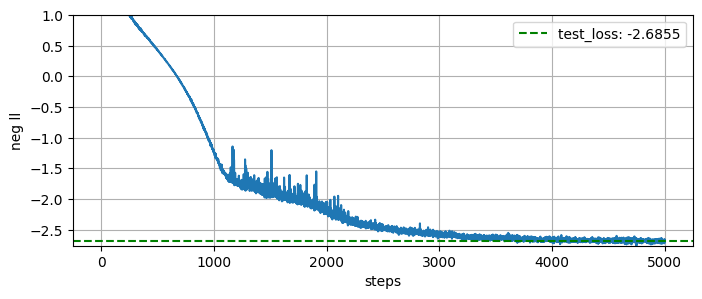

In [69]:
# Training the Feed Forward Network.

trained_models_evals = {}

for i, (n_layers, hidden_dim) in enumerate(MODEL_SIZES):
    print(f"\nTraining model {i+1}/{len(MODEL_SIZES)}: n_layers={n_layers}, hidden_dim={hidden_dim}")
    
    model = FeedForwardNetwork(n_layers, hidden_dim, jax.random.key(100 + i))
    stoch_vol_vehicle.train_model(
        TRAIN_KEY, 
        model,
        TRAIN_BATCH_SIZE, 
        learning_rate=1e-4,
        steps = 5000, 
        X_bar = X_BAR,
    )

    model_eval = loss(stoch_vol_vehicle.unvectorized_model, test_inputs, test_targets)
    trained_models_evals[(n_layers, hidden_dim)] = model_eval


In [70]:
print('Bootstrap model eval: ', boot_eval)
print('NNP model eval: ', model_eval)
print('Optimal model eval: ', optimal_eval)

Bootstrap model eval:  -2.584716
NNP model eval:  -2.6855738
Optimal model eval:  -2.6963766


## Model had been trained. 

We now need to run the particle filter.

In [77]:
N_PARTICLES = 2500

boot_particle_filter = ParticleFilter(
    f_sample_fn,
    g_likelihood_single,
    N_PARTICLES=N_PARTICLES,
    include_all_weights=True
)

nn_particle_filter = stoch_vol_vehicle.build_NN_particle_filter(
    N_PARTICLES=N_PARTICLES,
    include_all_weights=True
)

optimal_particle_filter = ParticleFilter(
    ar1_optimal_sample,
    ar1_optimal_likelihood_single,
    N_PARTICLES=N_PARTICLES,
    include_all_weights=True
)

# 1. Generate the data to run the particle filter on. 

N_RUNS = 2
N_TIMESTEPS = 1000

DATA_KEY = jax.random.key(65)
EVAL_KEY = jax.random.key(56)

# 1. Use the stochastic volatility vehicle to generate batched data 

print(f"Generating {N_RUNS} runs of data with {N_TIMESTEPS} timesteps each...")
x_vals, y_vals = stoch_vol_vehicle.generate_data(
    DATA_KEY, 
    N_RUNS,
    N_TIMESTEPS,
    X_BAR
)

INIT_PARTICLE_KEY = jax.random.key(16)
initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (N_PARTICLES,)) * 0.1 + X_BAR
initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)

# 2. Run all the particle filters

# Bootstrap Particle Filter
print("Running bootstrap particle filter simulations...")
_, _, bootstrap_diagnostics, bootstrap_output_particles_and_weights = jax.vmap(
    boot_particle_filter.simulate, in_axes=(0, None, None, 0, 0)
)(
    jax.random.split(EVAL_KEY, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)

# Neural Network Particle Filter
print("Running neural network particle filter simulations...")
_, _, nn_diagnostics, nn_output_particles_and_weights = jax.vmap(
    nn_particle_filter.simulate, in_axes=(0, None, None, 0, 0)
)(
    jax.random.split(EVAL_KEY, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)

# Optimal Particle Filter
print("Running optimal particle filter simulations...")
_, _, optimal_diagnostics, optimal_output_particles_and_weights = jax.vmap(
    optimal_particle_filter.simulate, in_axes=(0, None, None, 0, 0)
)(
    jax.random.split(EVAL_KEY, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)


Generating 2 runs of data with 1000 timesteps each...
Running bootstrap particle filter simulations...
Running neural network particle filter simulations...
Running optimal particle filter simulations...


Look at the ess values for the nn_particle_filter

Mean ESS (Neural Network PF): 1623.40
Mean ESS (Optimal PF): 1631.92
Mean ESS (Bootstrap PF): 1492.89


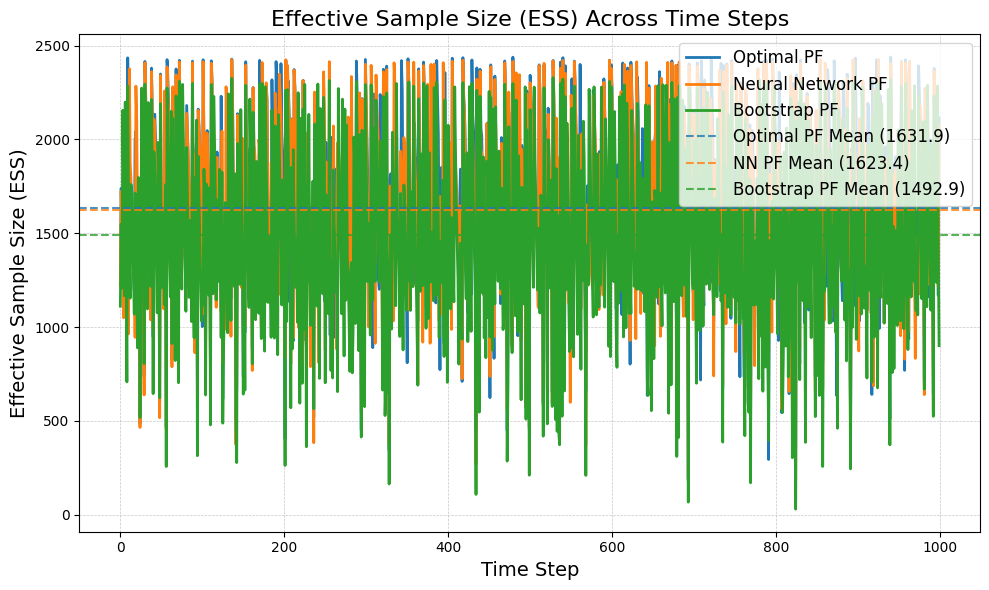

In [78]:
import matplotlib.ticker as mticker

# Calculate mean ESS for each filter
mean_ess_nn = jnp.mean(nn_diagnostics['ess'][0])
mean_ess_optimal = jnp.mean(optimal_diagnostics['ess'][0])
mean_ess_bootstrap = jnp.mean(bootstrap_diagnostics['ess'][0])

print(f"Mean ESS (Neural Network PF): {mean_ess_nn:.2f}")
print(f"Mean ESS (Optimal PF): {mean_ess_optimal:.2f}")
print(f"Mean ESS (Bootstrap PF): {mean_ess_bootstrap:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(optimal_diagnostics['ess'][0], label='Optimal PF', linewidth=2)
plt.plot(nn_diagnostics['ess'][0], label='Neural Network PF', linewidth=2)
plt.plot(bootstrap_diagnostics['ess'][0], label='Bootstrap PF', linewidth=2)

# Plot mean ESS as horizontal lines
plt.axhline(mean_ess_optimal, color='C0', linestyle='--', linewidth=1.5, alpha=0.8,
            label=f'Optimal PF Mean ({mean_ess_optimal:.1f})')
plt.axhline(mean_ess_nn, color='C1', linestyle='--', linewidth=1.5, alpha=0.8,
            label=f'NN PF Mean ({mean_ess_nn:.1f})')
plt.axhline(mean_ess_bootstrap, color='C2', linestyle='--', linewidth=1.5, alpha=0.8,
            label=f'Bootstrap PF Mean ({mean_ess_bootstrap:.1f})')

plt.title("Effective Sample Size (ESS) Across Time Steps", fontsize=16)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Effective Sample Size (ESS)", fontsize=14)
plt.legend(fontsize=12, loc='upper right', frameon=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [79]:
arg_sorted_nn_ess = np.argsort(nn_diagnostics['ess'][0])
first_three = arg_sorted_nn_ess[:5]
last_three = arg_sorted_nn_ess[-5:]
rand_three = np.random.choice(arg_sorted_nn_ess, 5, replace=False)

In [80]:
print(first_three)
print(last_three)
print(rand_three)


[824 693 434 568 141]
[894 202 854 925 136]
[184 617 963 418 185]


Now that we have evaluated the particle filter we should begin writing the QQ-plot function

In [81]:
def create_qq_plot(output_particles_and_weights, x_vals, y_vals, point_to_plot, nn_ess, opt_ess, boot_ess):
    # 1. Unpack the particles and weights.
    particles, weights = output_particles_and_weights
    particles, weights = particles.at[point_to_plot].get(), weights.at[point_to_plot].get()
    particles, weights = np.array(particles), np.array(weights)

    x_vals = np.array(x_vals)
    prev_x = x_vals[point_to_plot - 1]
    true_x = x_vals[point_to_plot]
    
    # 2. Prepare for QQ-plot.
    quantiles_to_take = np.linspace(0, 1, 100)
    quantiles_of_interest = np.quantile(particles, quantiles_to_take, axis=0, method='inverted_cdf', weights=weights)

    # 3. True distribution. 
    # Bootstrap
    true_mean, true_std = f_mean_func(prev_x), f_std_func(prev_x)
    true_quantiles = stats.norm.ppf(quantiles_to_take, true_mean, true_std)
    
    # Optimal
    optimal_mean = optimal_mean_func(prev_x, y_vals[point_to_plot])
    optimal_std = optimal_std_func(prev_x, y_vals[point_to_plot])
    optimal_quantiles = stats.norm.ppf(quantiles_to_take, optimal_mean, optimal_std)
    
    # Quantile of the true value under the NNP proposal (particle filter)
    # This is the weighted CDF of the particles at true_x
    def weighted_cdf(x, samples, weights):
        # Returns the weighted CDF value at x
        idx = np.argsort(samples)
        samples_sorted = samples[idx]
        weights_sorted = weights[idx]
        cum_weights = np.cumsum(weights_sorted)
        cum_weights = cum_weights / cum_weights[-1]
        # Find where true_x would be inserted
        insert_idx = np.searchsorted(samples_sorted, x, side='right')
        if insert_idx == 0:
            return 0.0
        elif insert_idx >= len(samples_sorted):
            return 1.0
        else:
            return cum_weights[insert_idx-1]
    nnp_true_x_quantile = weighted_cdf(true_x, particles, weights)

    # 4. Make the plot (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    # Subplot 1: QQ plot (Bootstrap)
    axes[0].plot(quantiles_of_interest, true_quantiles, marker='o', linestyle='', label='Particle Quantiles')
    axes[0].plot(true_quantiles, true_quantiles, 'k--', label='y=x (Ideal)')
    # Add the true_x as a red star on the QQ plot
    true_x_quantile = stats.norm.cdf(true_x, loc=true_mean, scale=true_std)
    pf_quantile = np.quantile(particles, true_x_quantile, method='inverted_cdf', weights=weights)
    axes[0].plot(pf_quantile, stats.norm.ppf(true_x_quantile, true_mean, true_std), 'r*', markersize=15, label='True $x_t$')
    axes[0].set_title(f'QQ Plot (Bootstrap) at t={point_to_plot}')
    axes[0].set_xlabel('NNP Proposals Quantiles')
    axes[0].set_ylabel('Bootstrap Quantiles')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].text(
        0.05, 0.95, 
        f"NN ESS: {nn_ess:.2f}\nBoot ESS: {boot_ess:.2f}\n"
        f"True $x_t$ quantile (bootstrap): {true_x_quantile:.3f}\n"
        f"True $x_t$ quantile (NNP): {nnp_true_x_quantile:.3f}",
        transform=axes[0].transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    # Subplot 2: QQ plot (Optimal)
    axes[1].plot(quantiles_of_interest, optimal_quantiles, marker='o', linestyle='', label='Particle Quantiles')
    axes[1].plot(optimal_quantiles, optimal_quantiles, 'k--', label='y=x (Ideal)')
    optimal_x_quantile = stats.norm.cdf(true_x, loc=optimal_mean, scale=optimal_std)
    pf_quantile_opt = np.quantile(particles, optimal_x_quantile, method='inverted_cdf', weights=weights)
    axes[1].plot(pf_quantile_opt, stats.norm.ppf(optimal_x_quantile, optimal_mean, optimal_std), 'r*', markersize=15, label='True $x_t$')
    axes[1].set_title(f'QQ Plot (Optimal) at t={point_to_plot}')
    axes[1].set_xlabel('NNP Proposals Quantiles')
    axes[1].set_ylabel('Optimal Quantiles')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].text(
        0.05, 0.95, 
        f"NN ESS: {nn_ess:.2f}\nOpt ESS: {opt_ess:.2f}\nTrue $x_t$ quantile: {optimal_x_quantile:.3f}",
        transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    # Subplot 3: Cumulative sorted weight function
    sorted_indices = np.argsort(weights)
    sorted_weights = weights[sorted_indices]
    cum_weights = np.cumsum(sorted_weights)
    cum_weights /= cum_weights[-1]  # Normalize to 1

    axes[2].plot(cum_weights, label='Cumulative Weight')
    n = len(cum_weights)
    axes[2].plot(np.linspace(0, n-1, n), np.linspace(0, 1, n), 'k--', label='y=x (Ideal)')
    axes[2].set_title(f'Cumulative Sorted Weight Function at t={point_to_plot}')
    axes[2].set_xlabel('Particle Index (sorted)')
    axes[2].set_ylabel('Cumulative Weight')
    axes[2].legend()
    axes[2].grid(True)
    axes[2].text(
        0.05, 0.95, f"NN ESS: {nn_ess:.2f}",
        transform=axes[2].transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    # Subplot 4: Weighted histogram of particles
    axes[3].hist(particles, bins=30, weights=weights, alpha=0.7, color='tab:blue', edgecolor='black', label='Weighted Particles')
    # Overlay true distribution (bootstrap) and optimal as lines
    x_min, x_max = np.min(particles), np.max(particles)
    x_grid = np.linspace(x_min, x_max, 200)
    axes[3].plot(x_grid, stats.norm.pdf(x_grid, true_mean, true_std) * np.sum(weights) * (x_max-x_min)/30, 
                 color='tab:orange', lw=2, label='Bootstrap PDF')
    axes[3].plot(x_grid, stats.norm.pdf(x_grid, optimal_mean, optimal_std) * np.sum(weights) * (x_max-x_min)/30, 
                 color='tab:green', lw=2, label='Optimal PDF')
    axes[3].axvline(true_x, color='red', linestyle='--', label='True $x_t$')
    # Plot the true y value as a vertical line on the histogram
    true_y = y_vals[point_to_plot]
    axes[3].axvline(true_y, color='purple', linestyle='-', linewidth=2, label='True $y_t$')
    axes[3].set_title(f'Weighted Particle Histogram at t={point_to_plot}')
    axes[3].set_xlabel('Particle Value')
    axes[3].set_ylabel('Weighted Count')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

worst


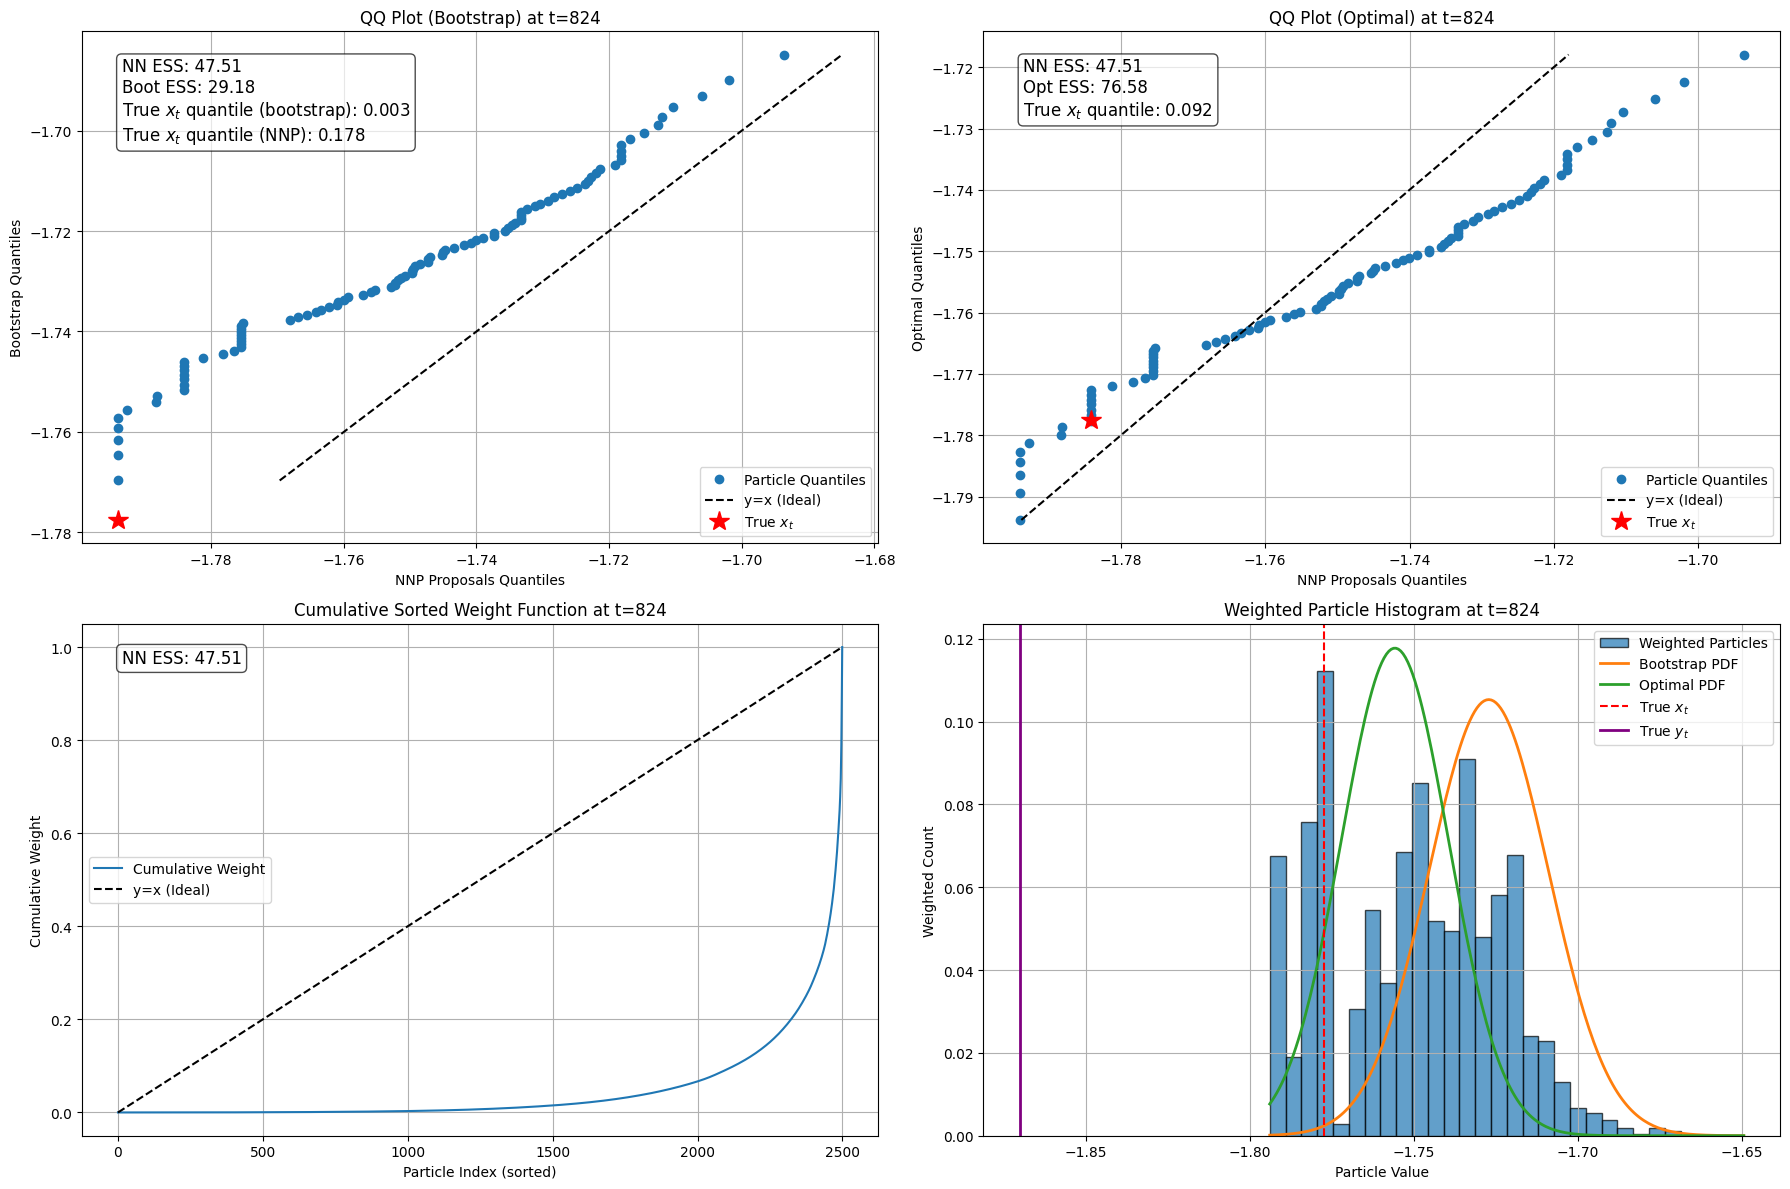

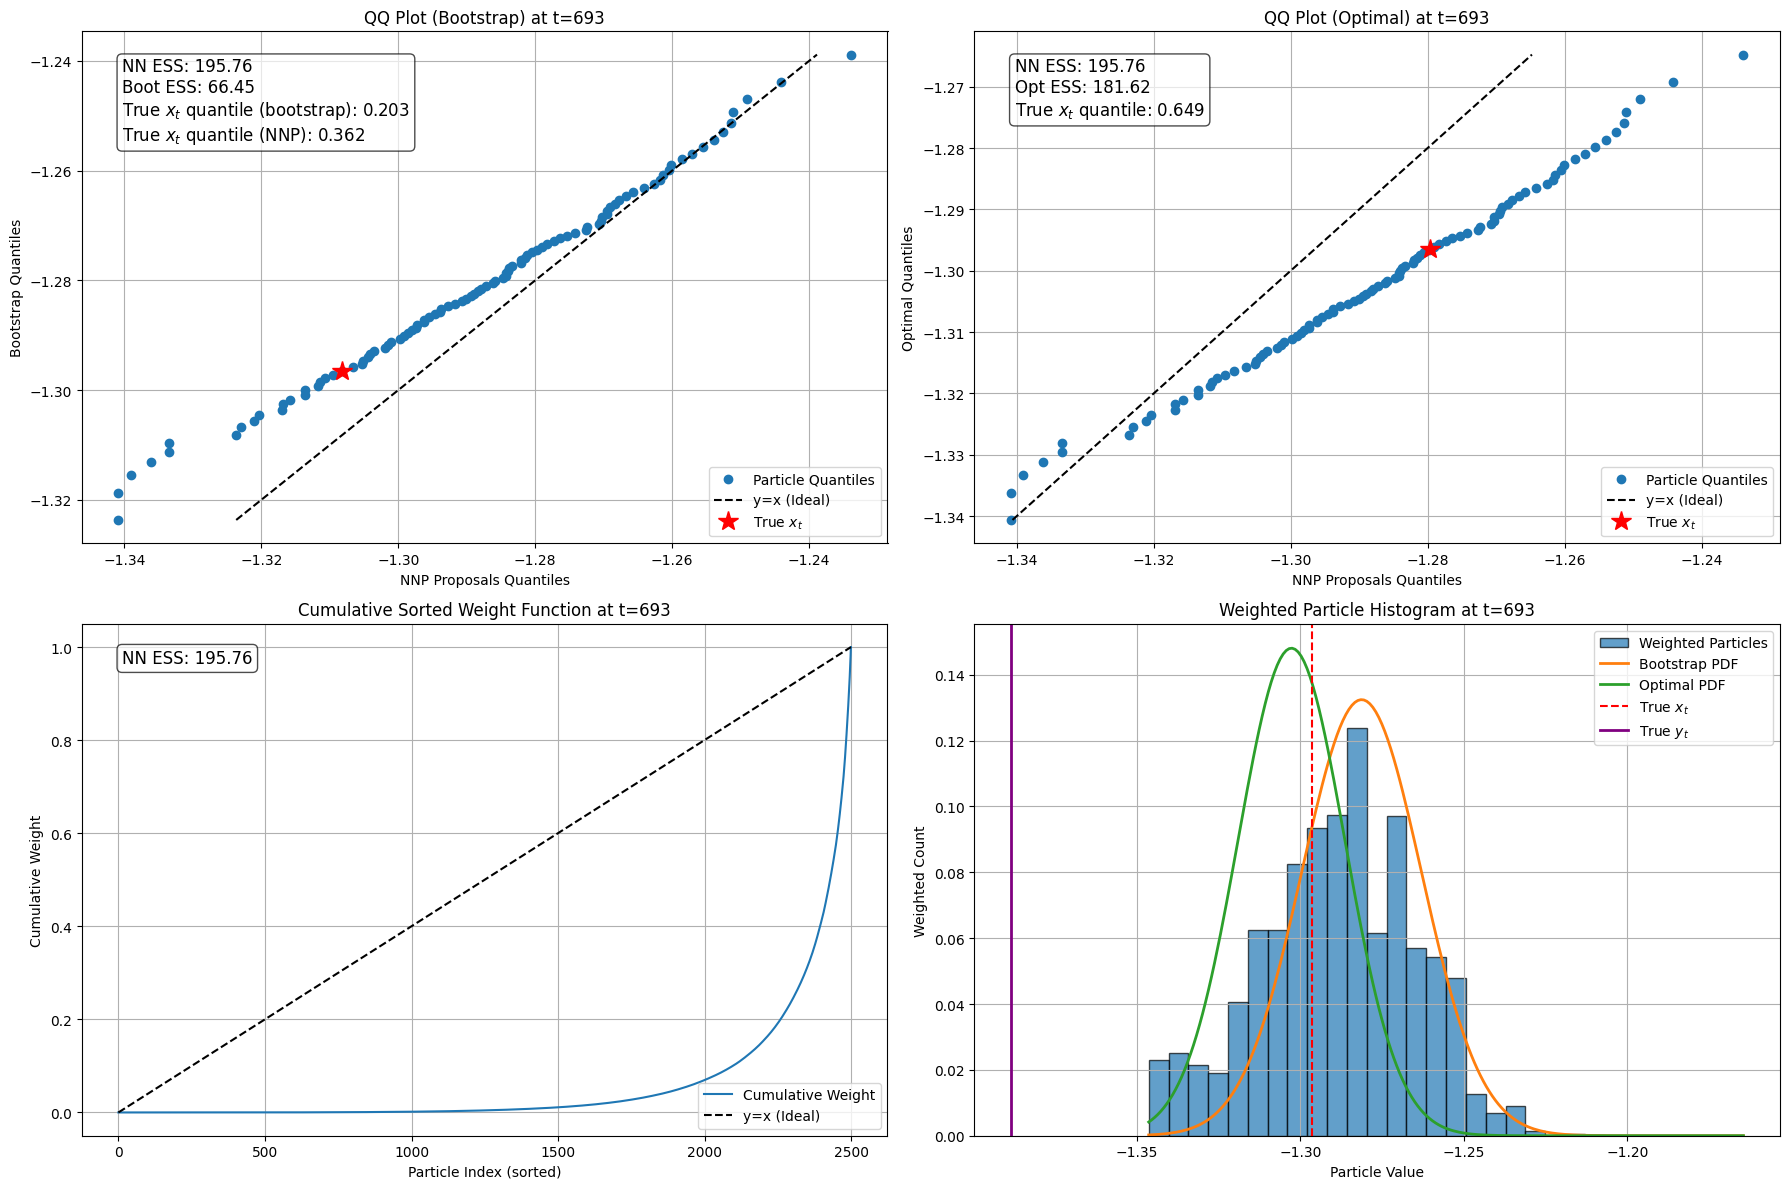

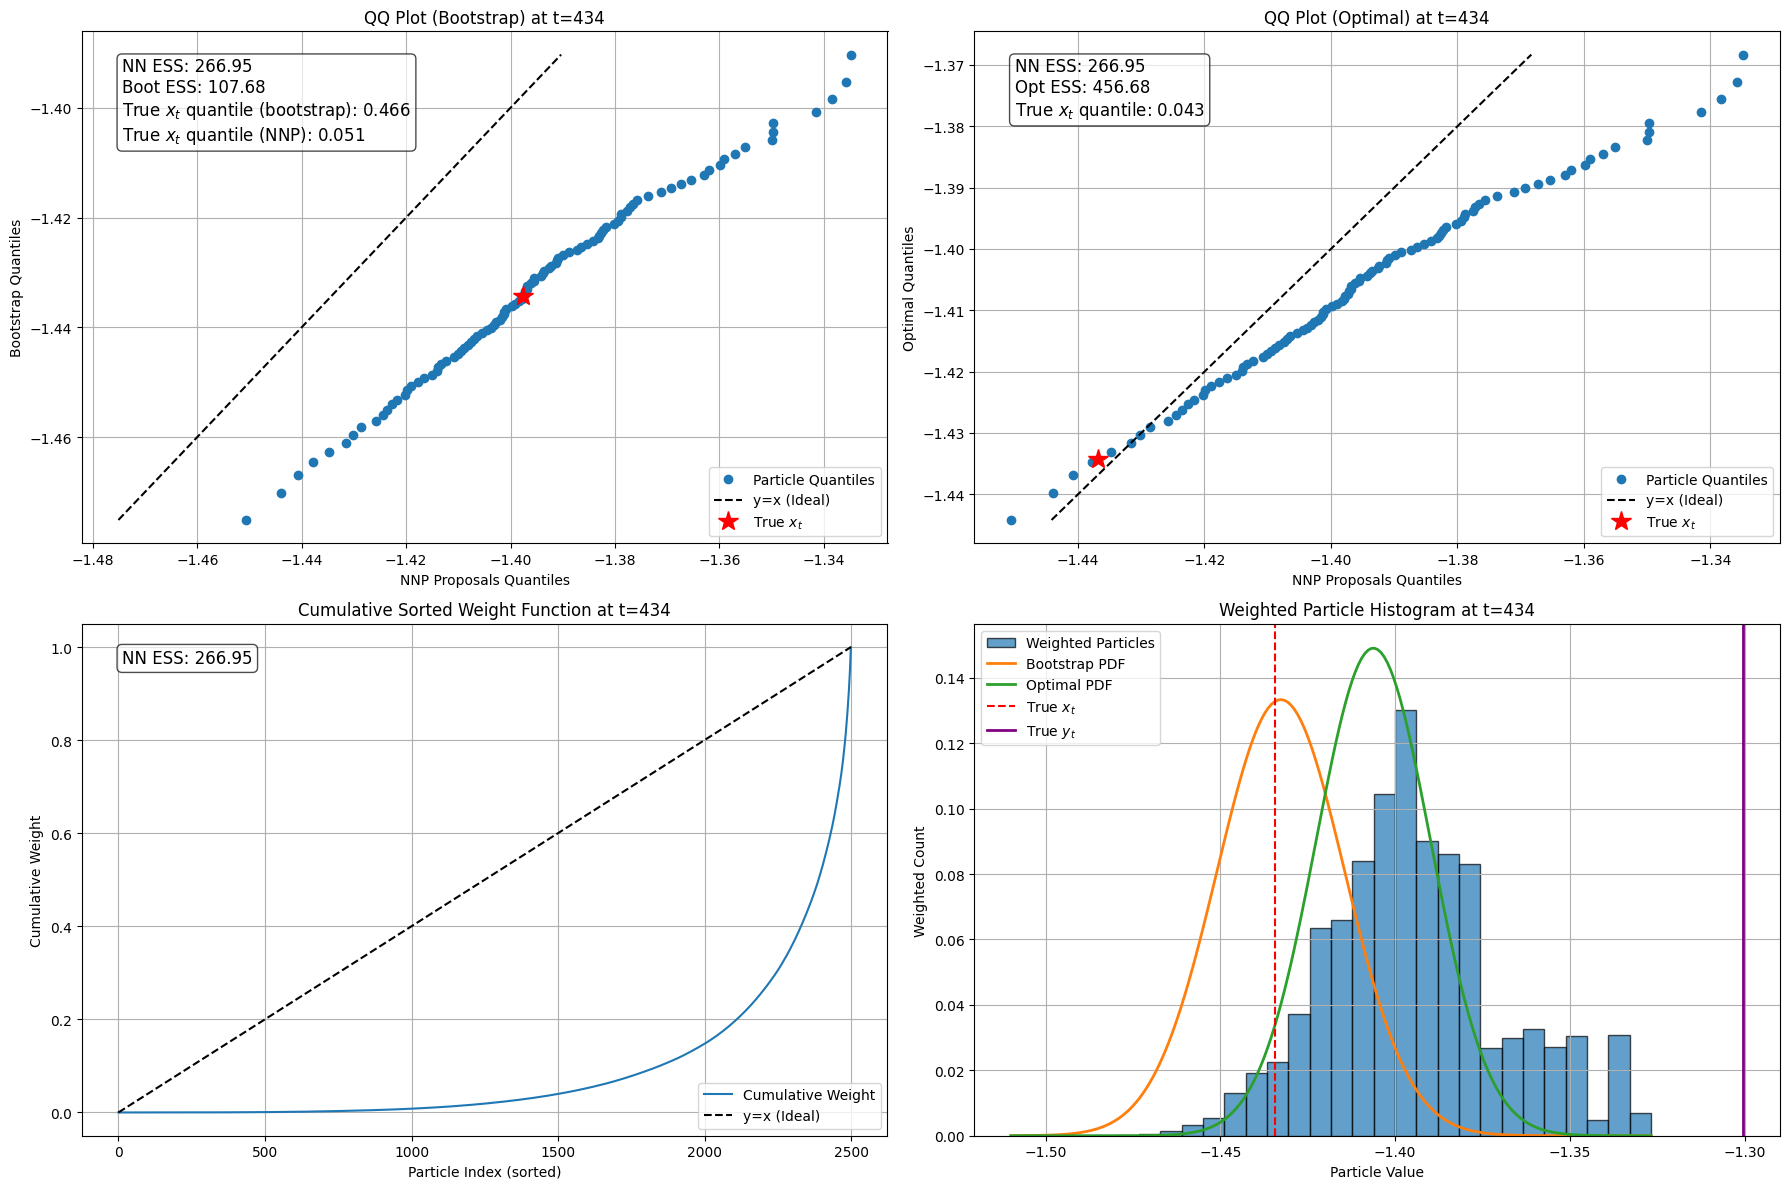

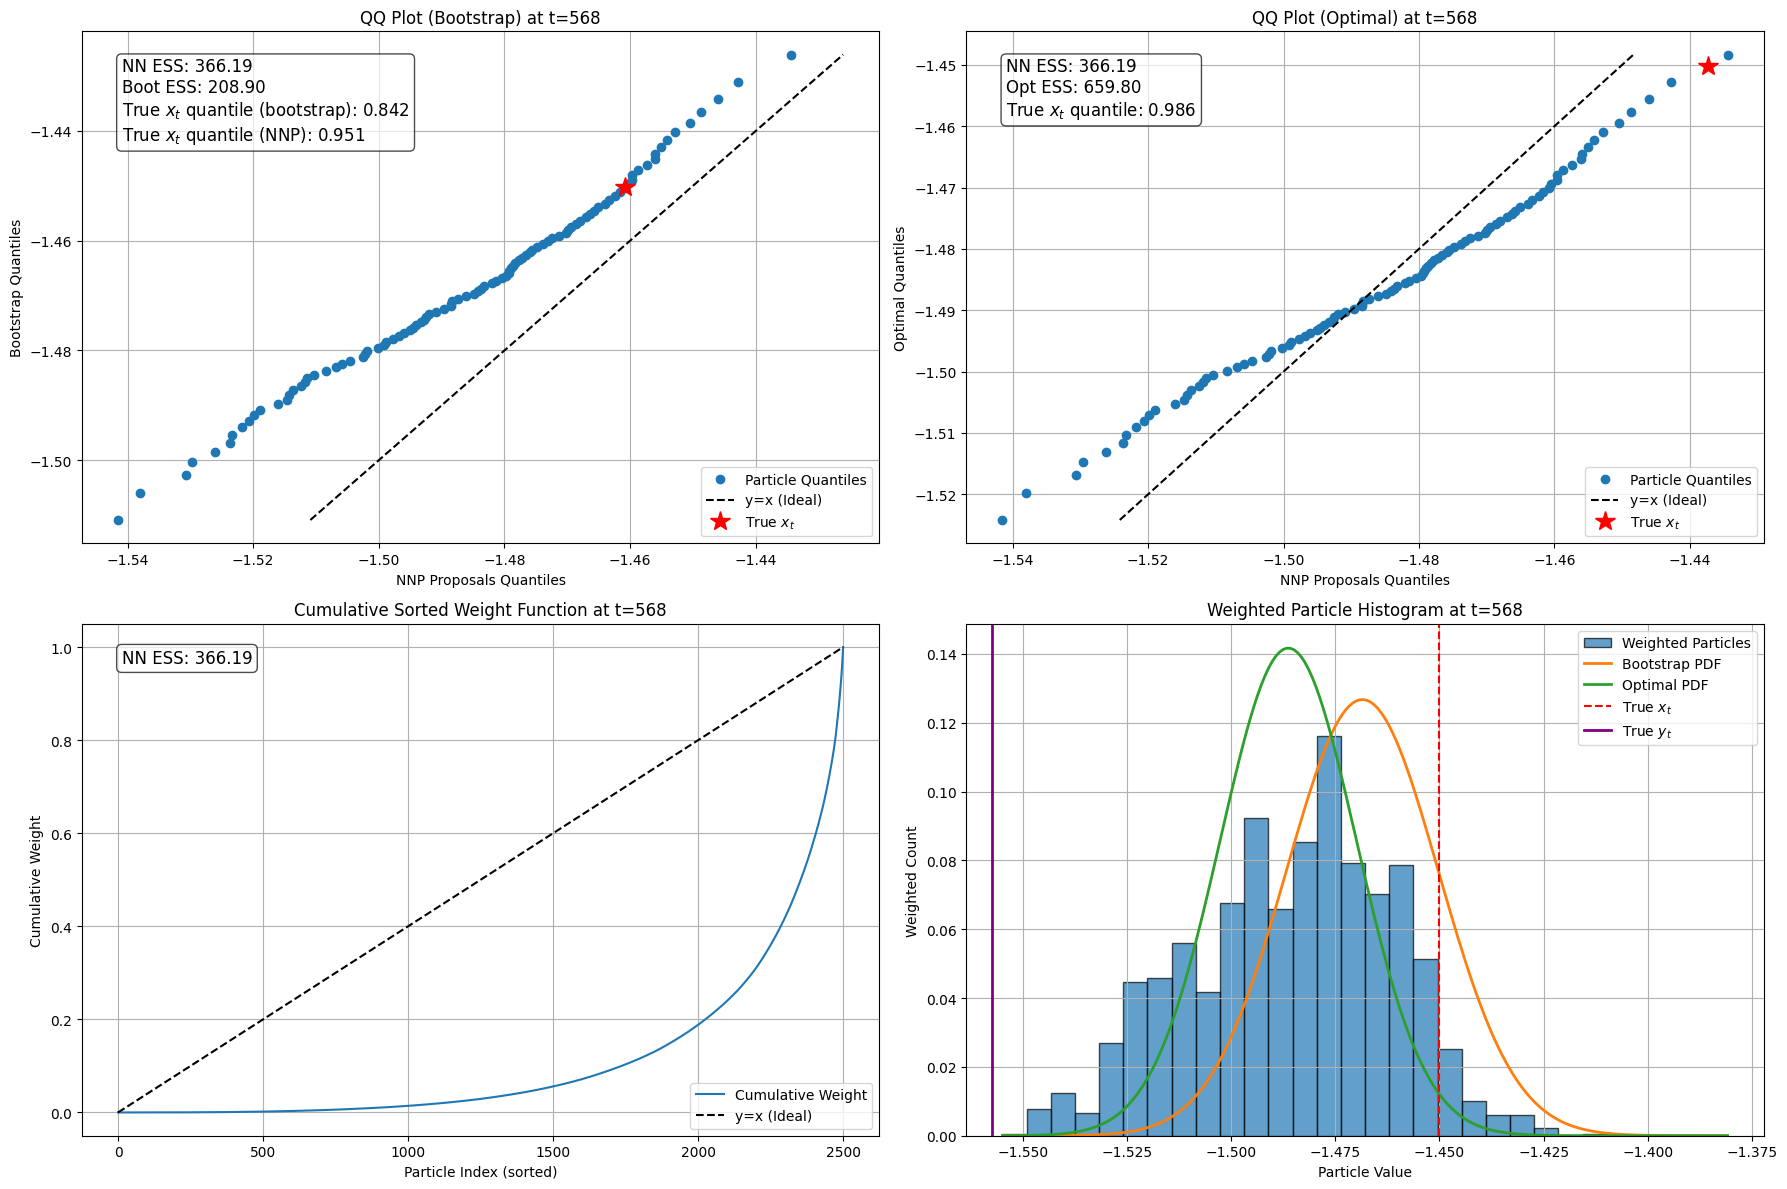

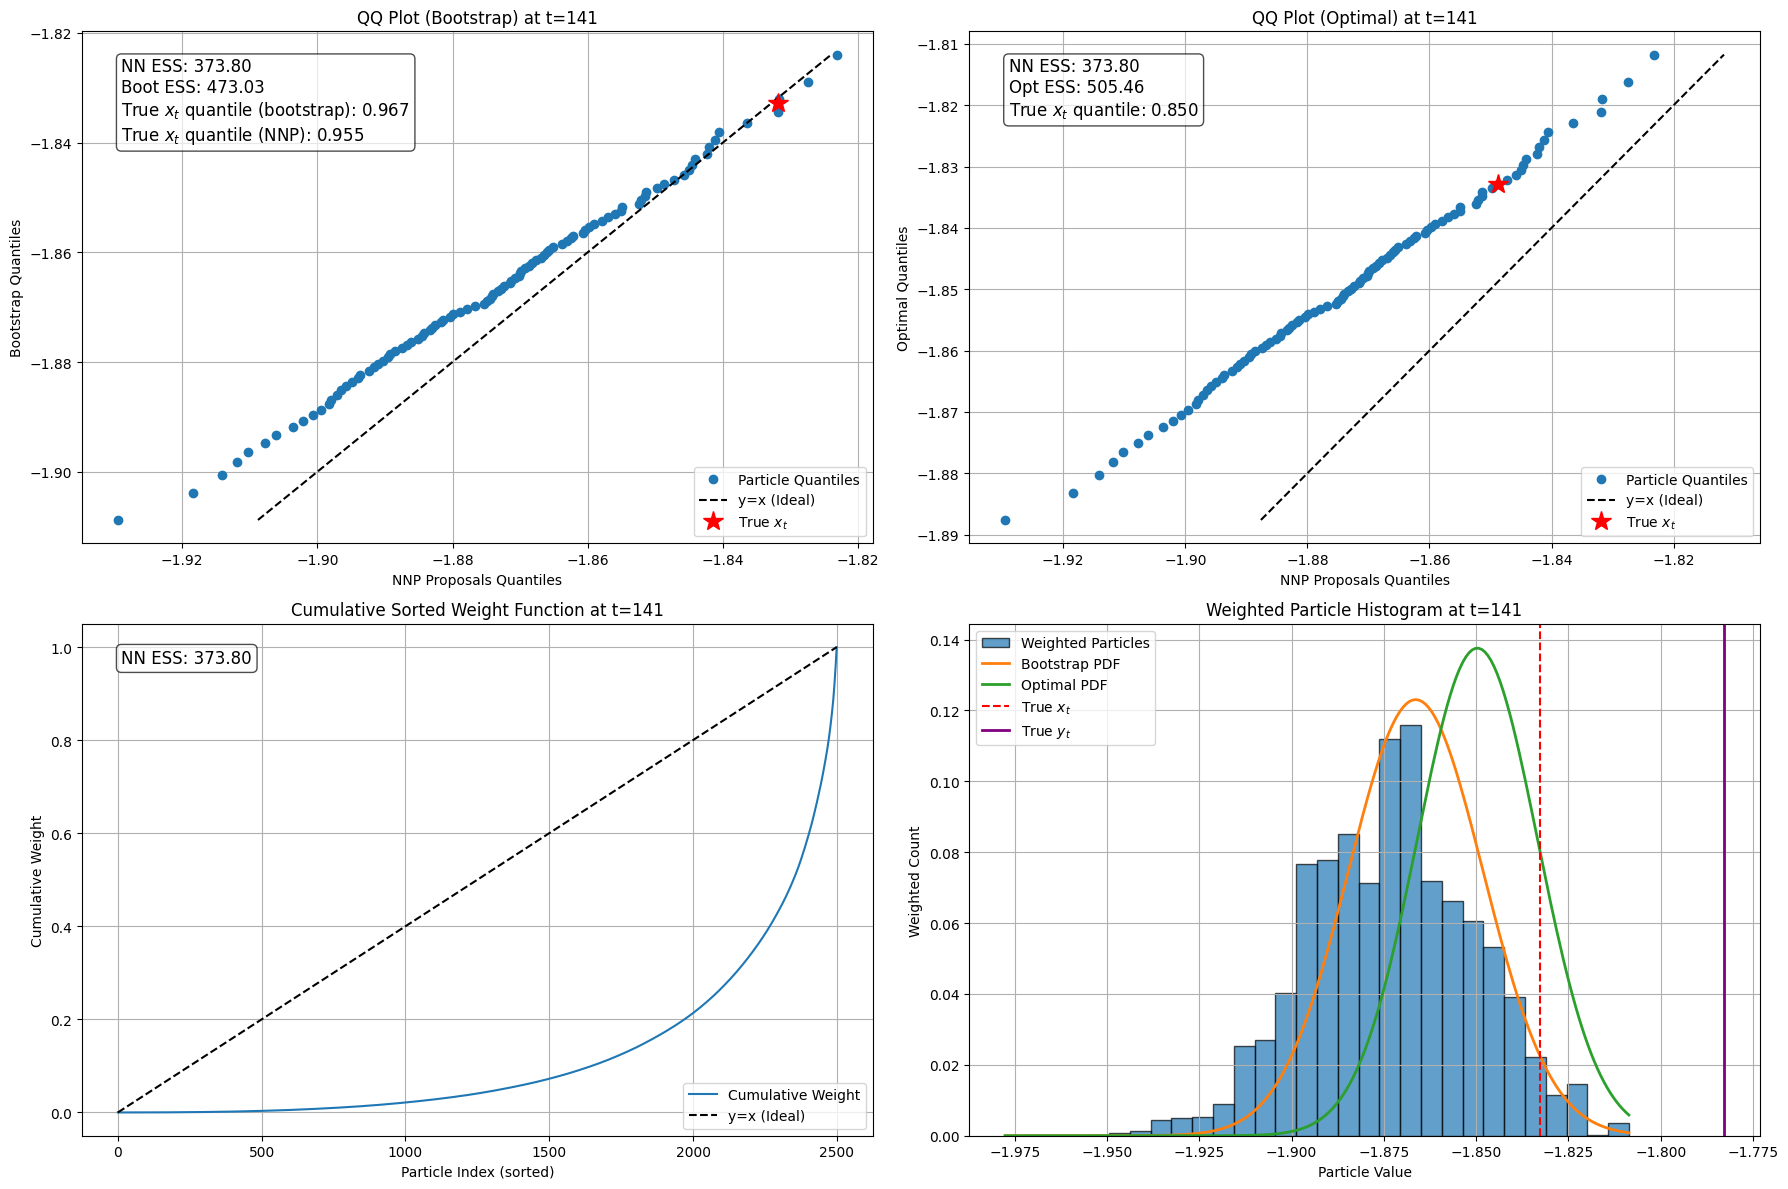

best


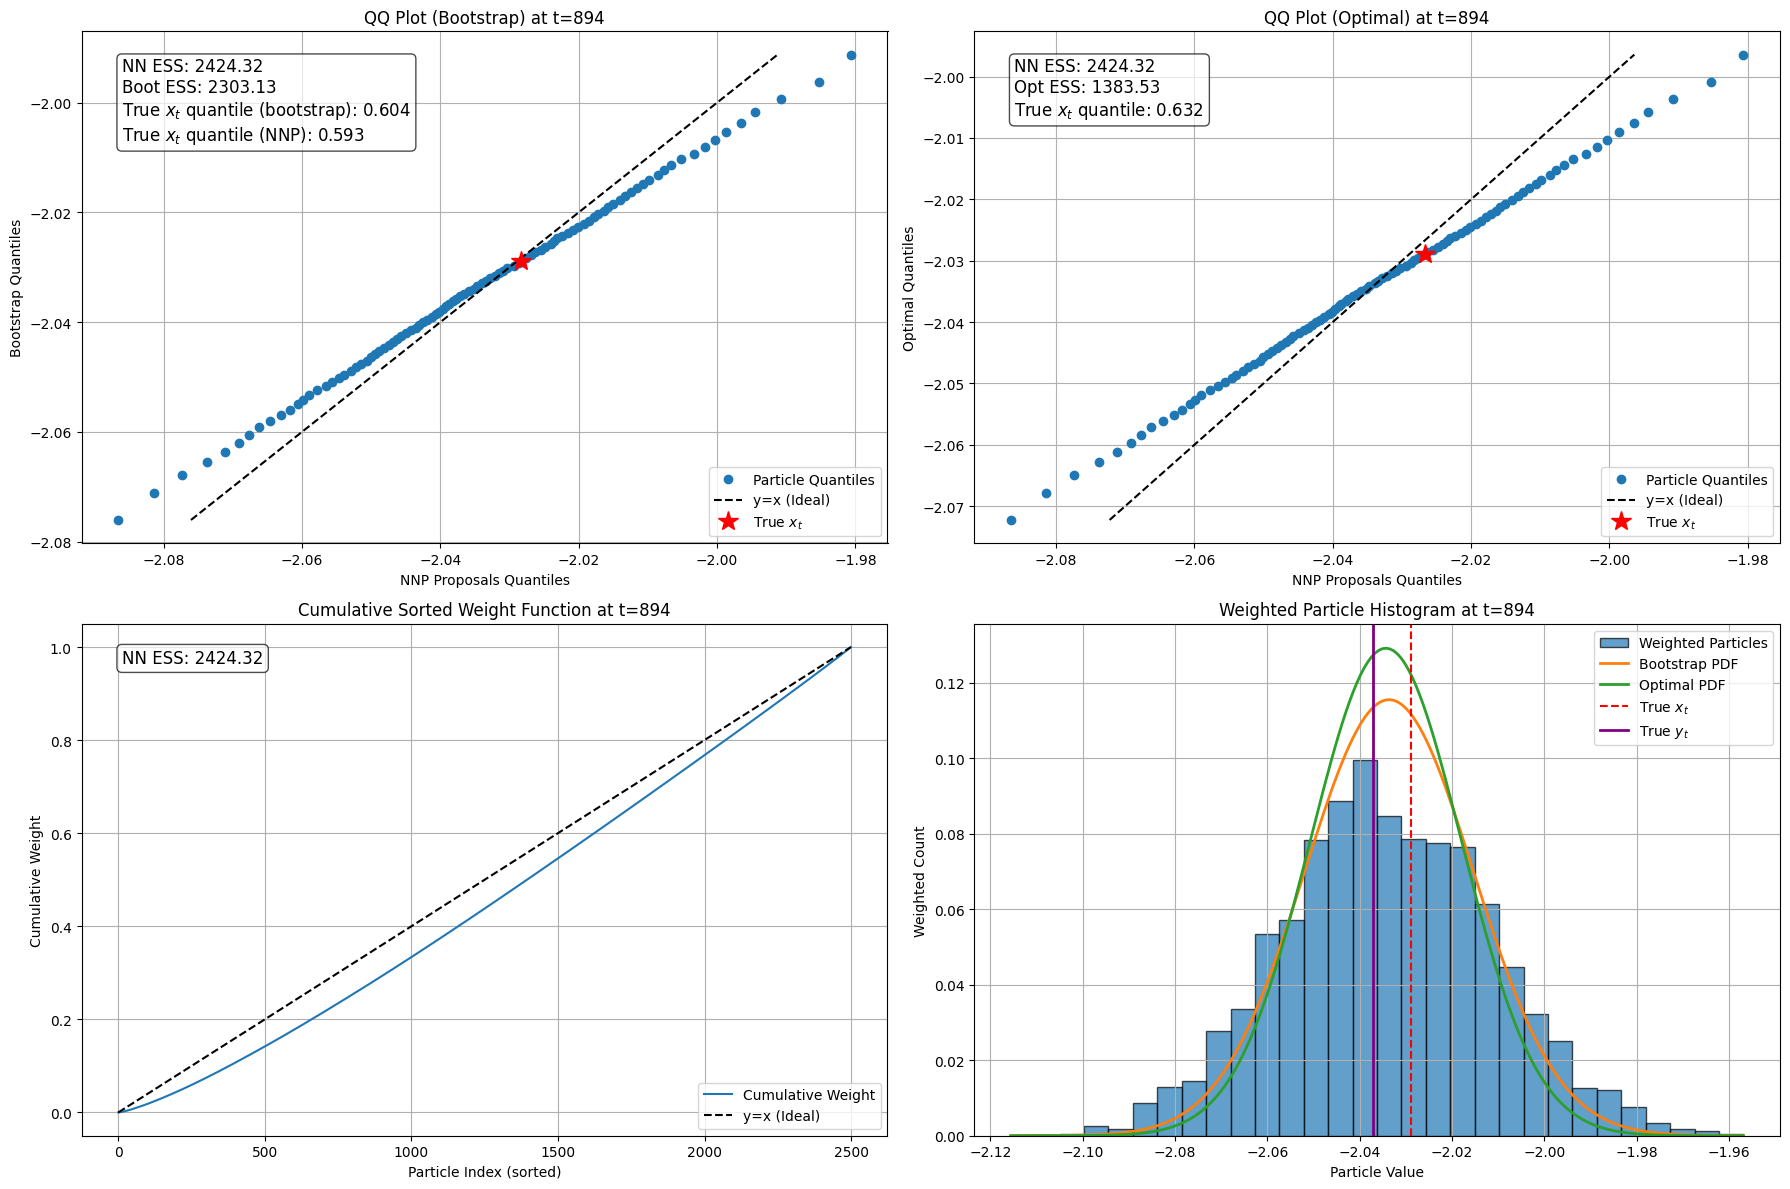

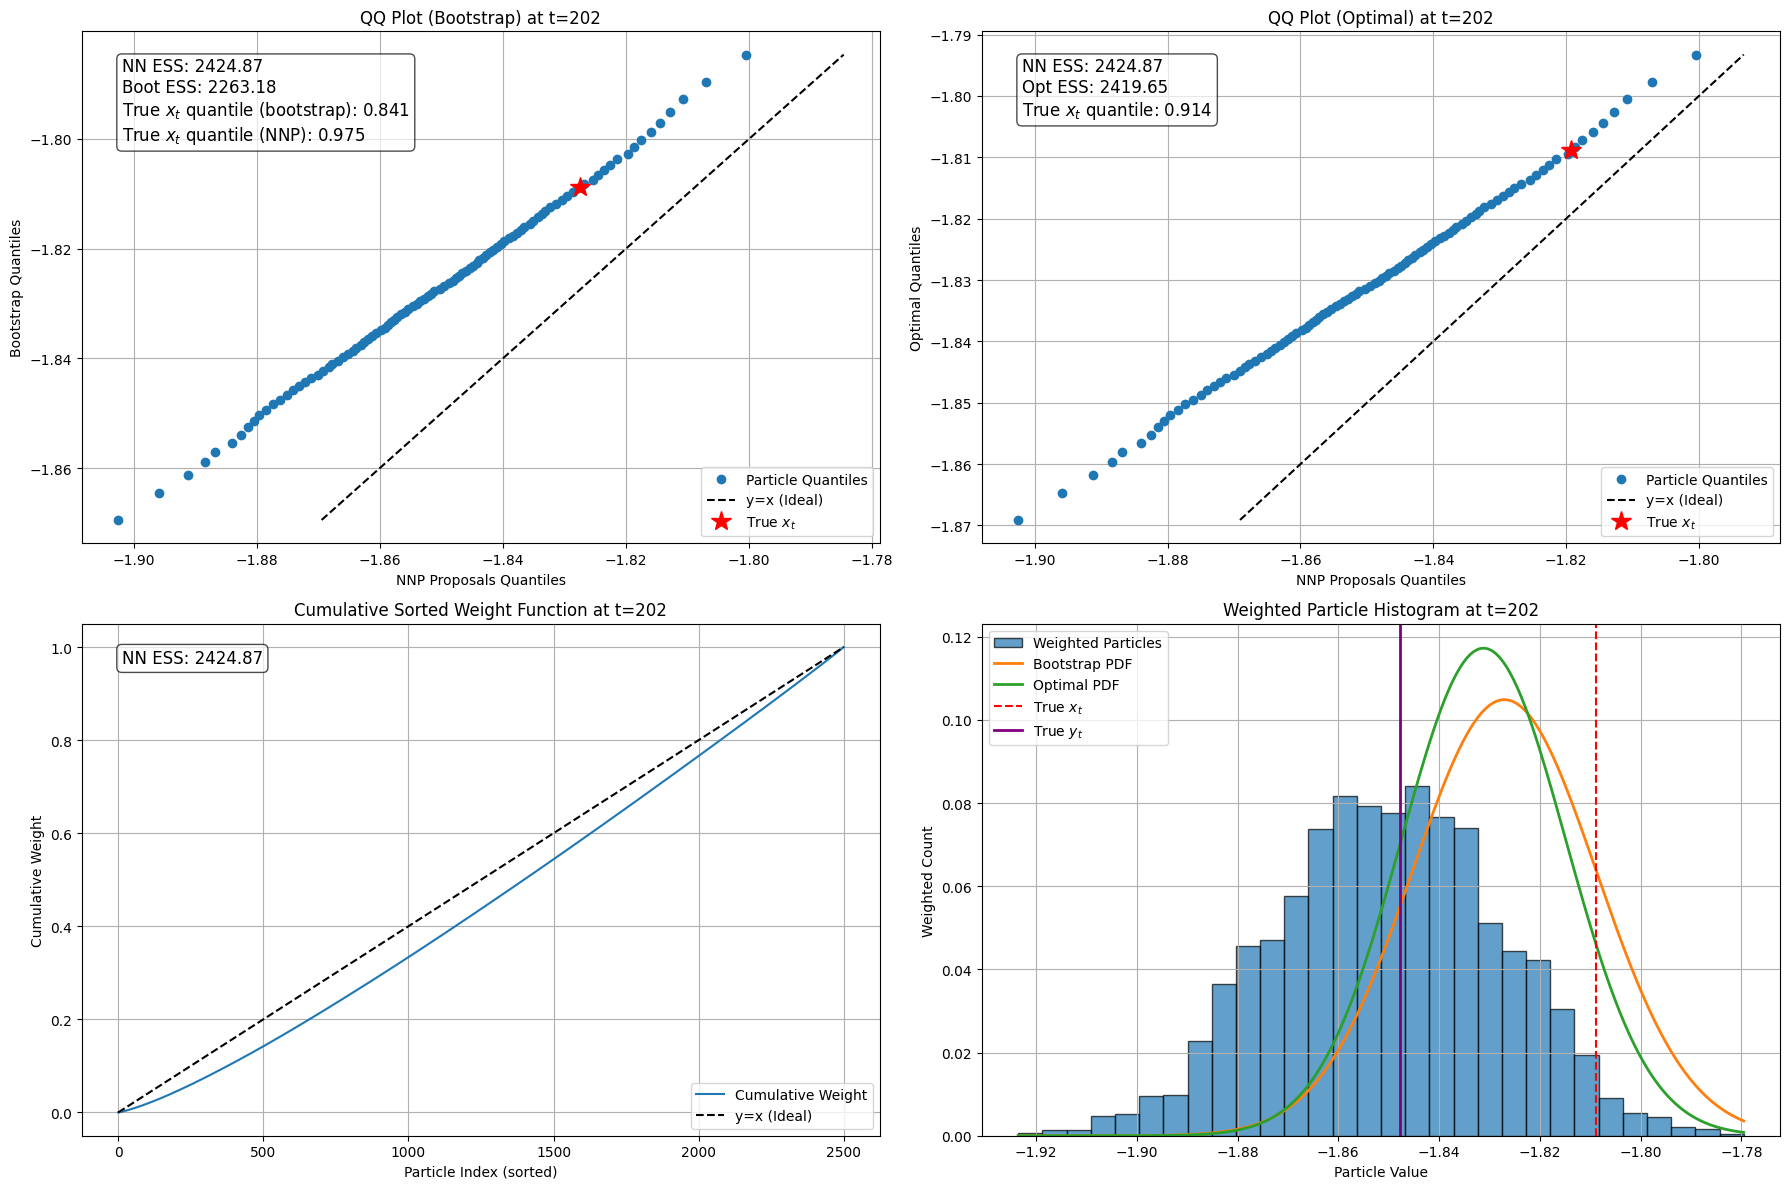

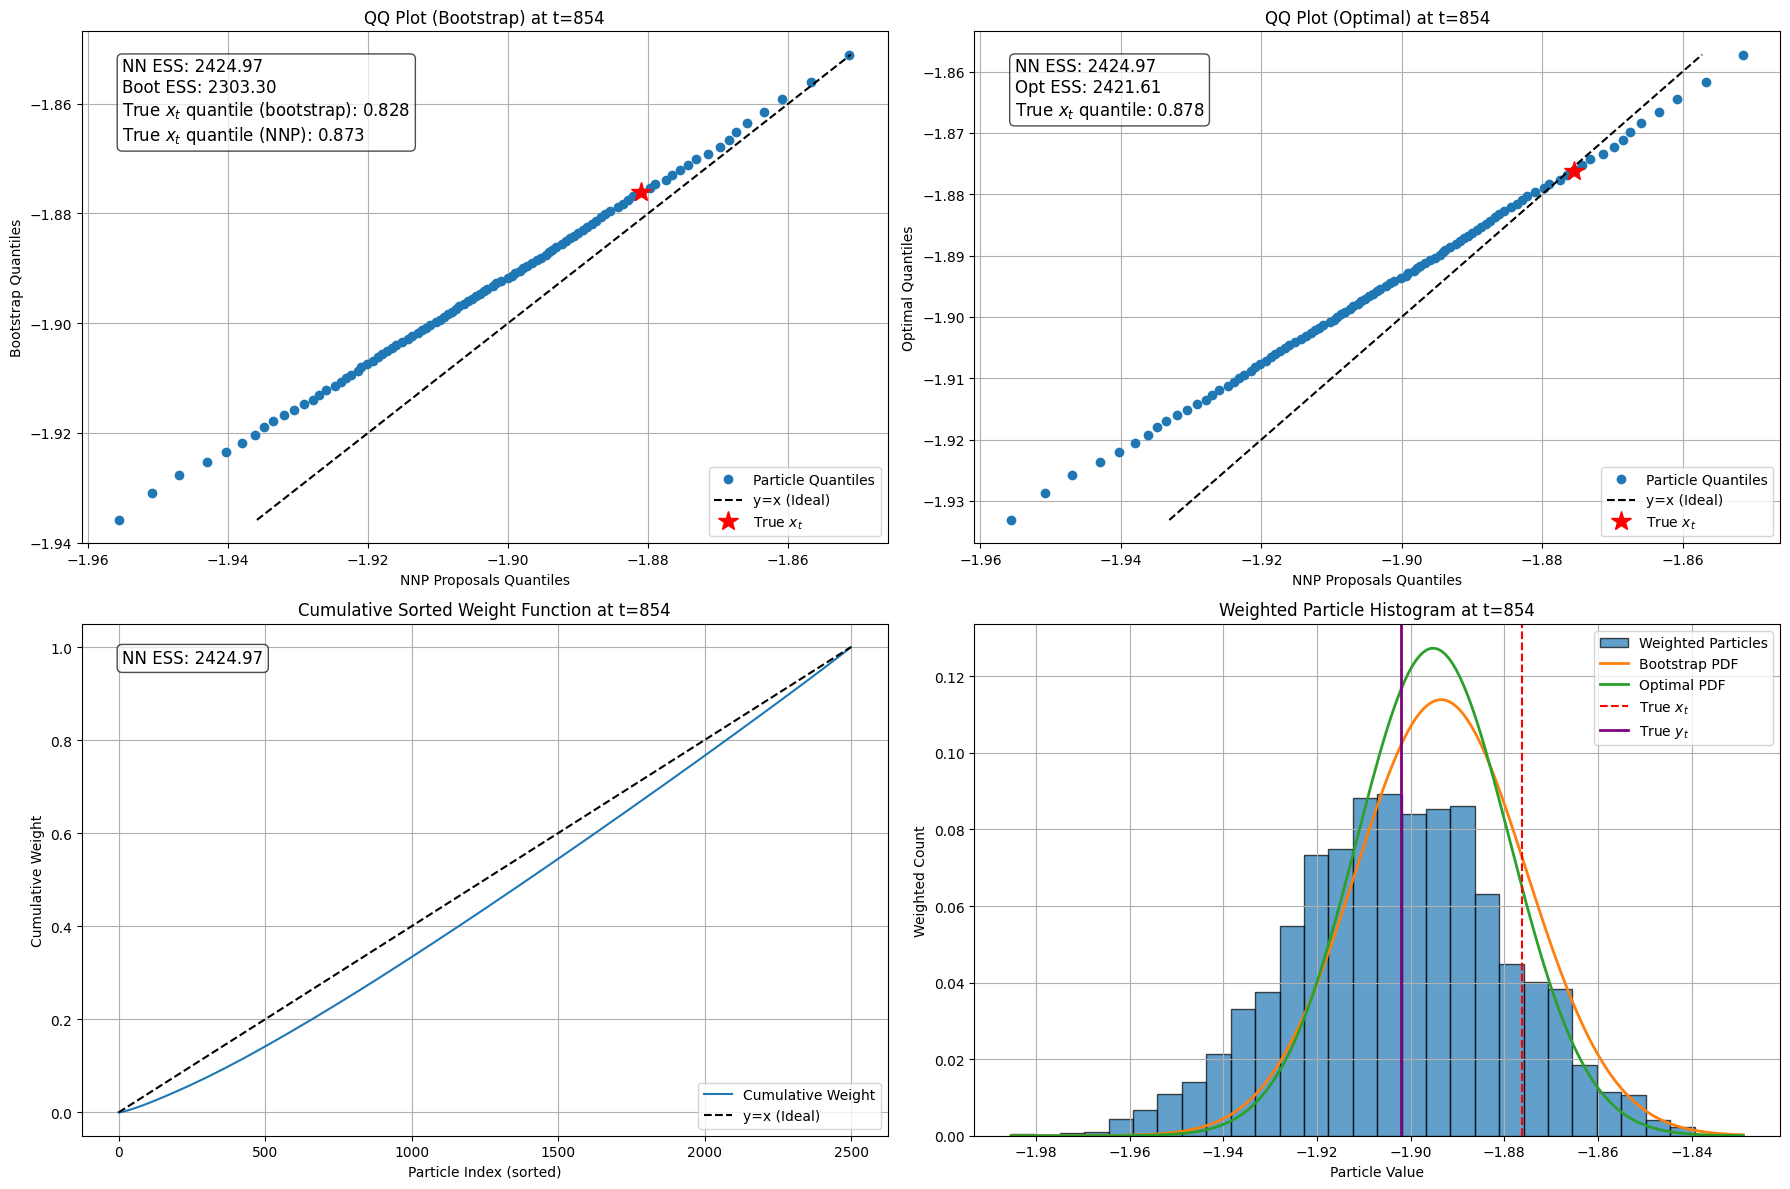

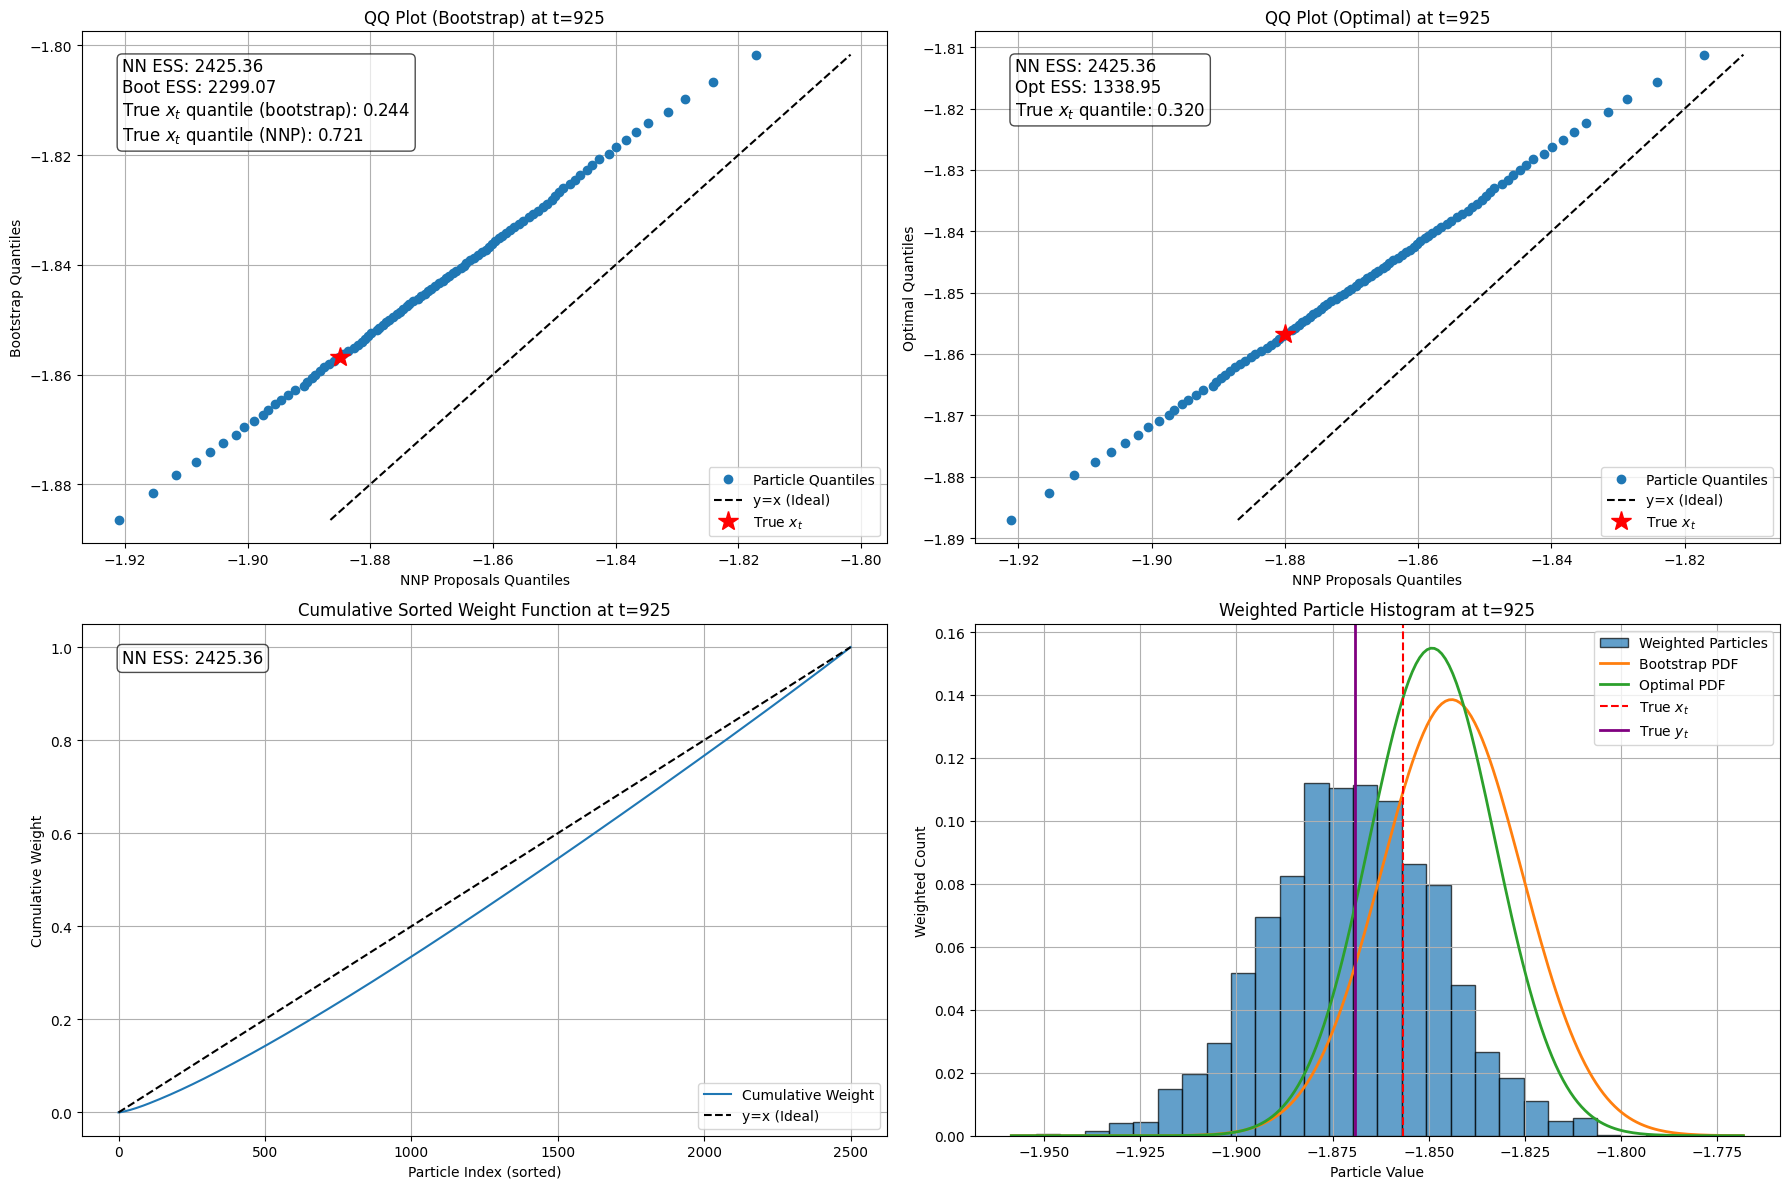

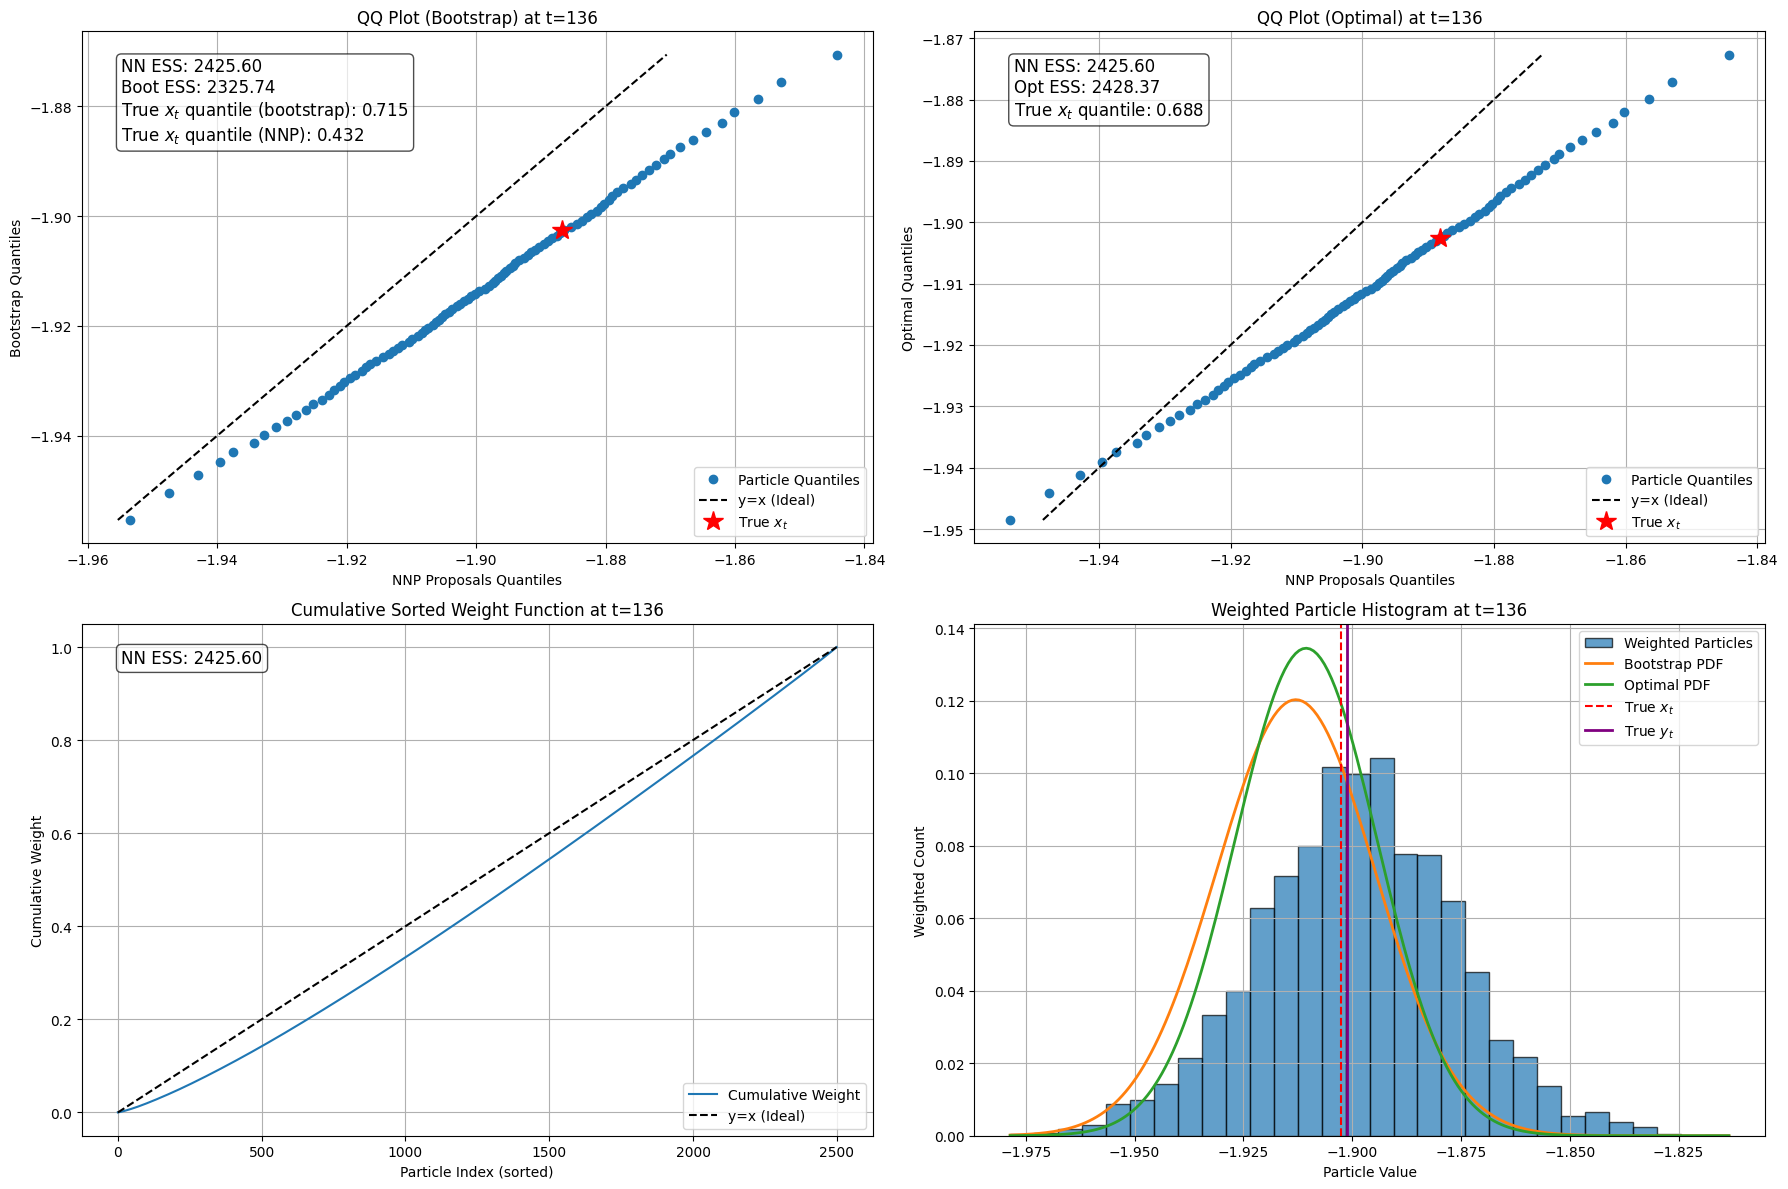

random


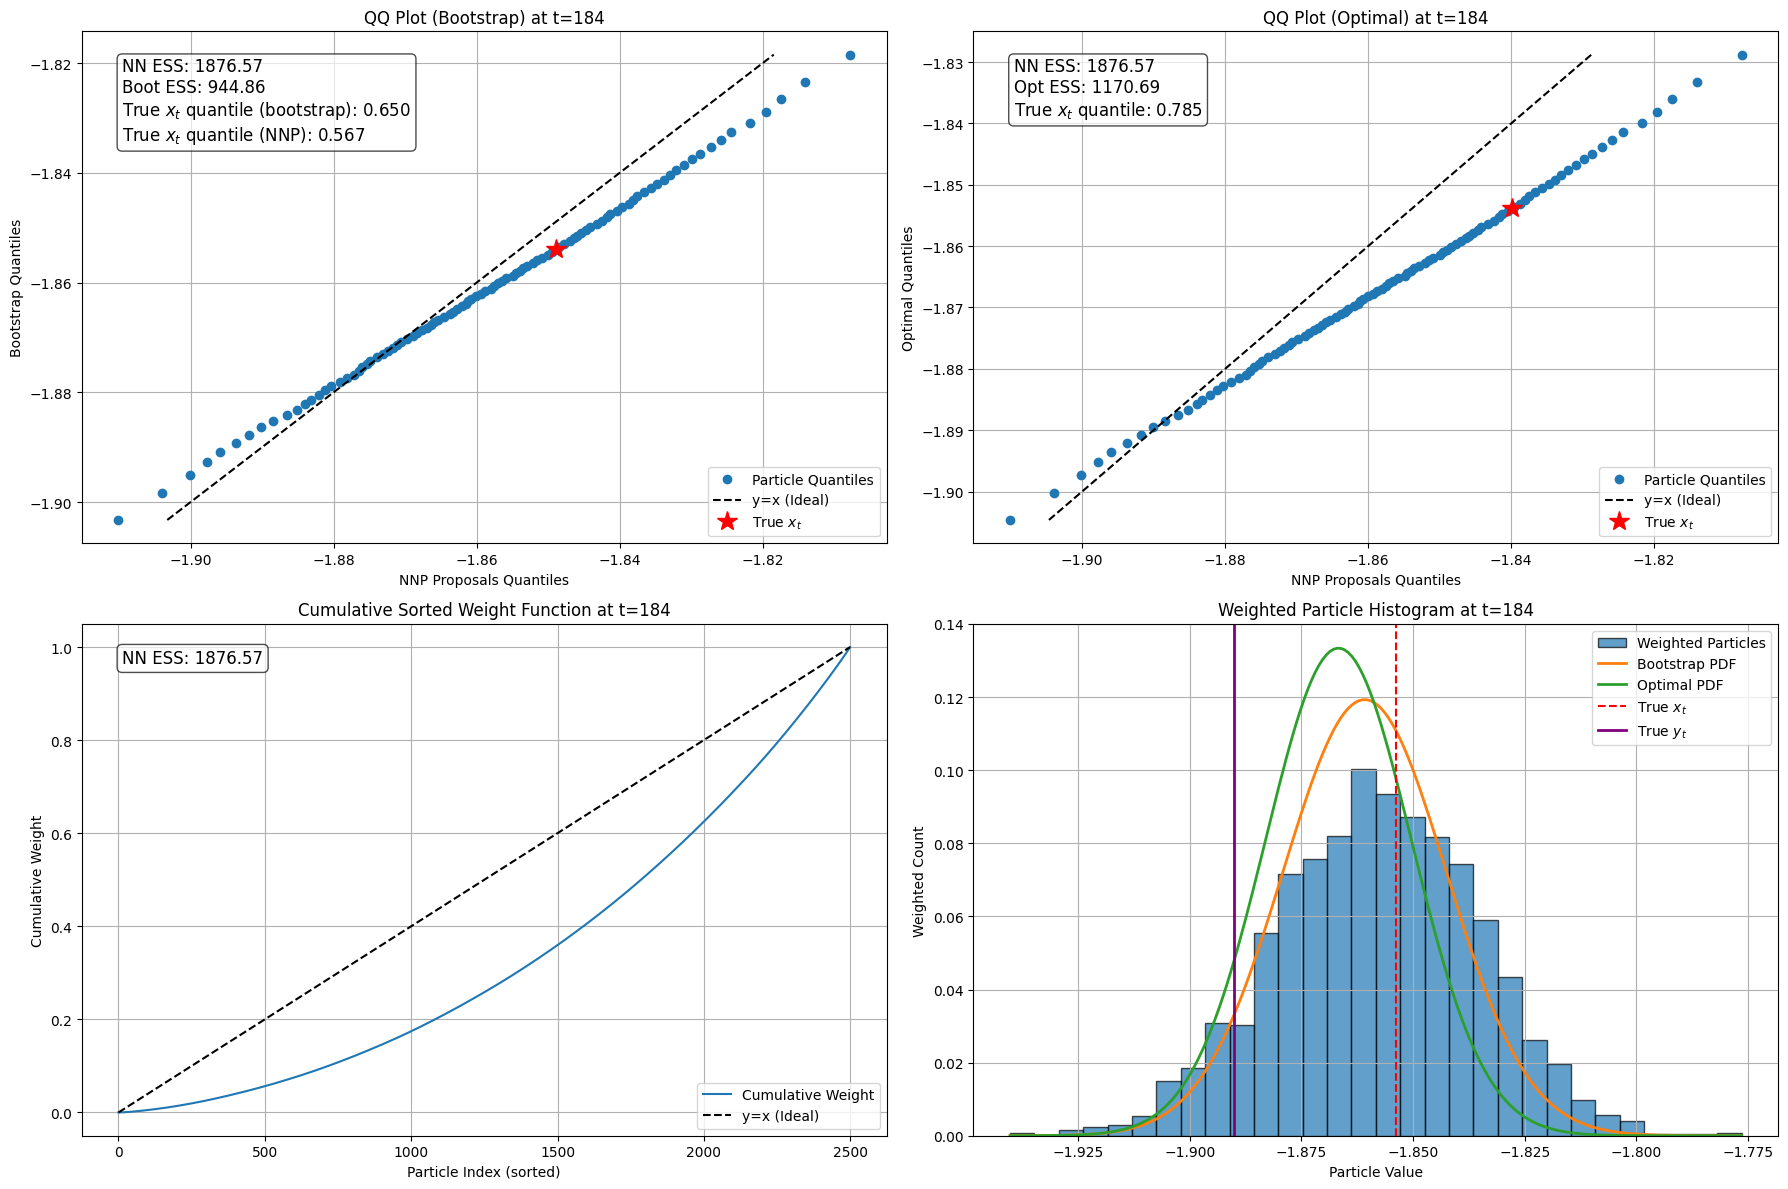

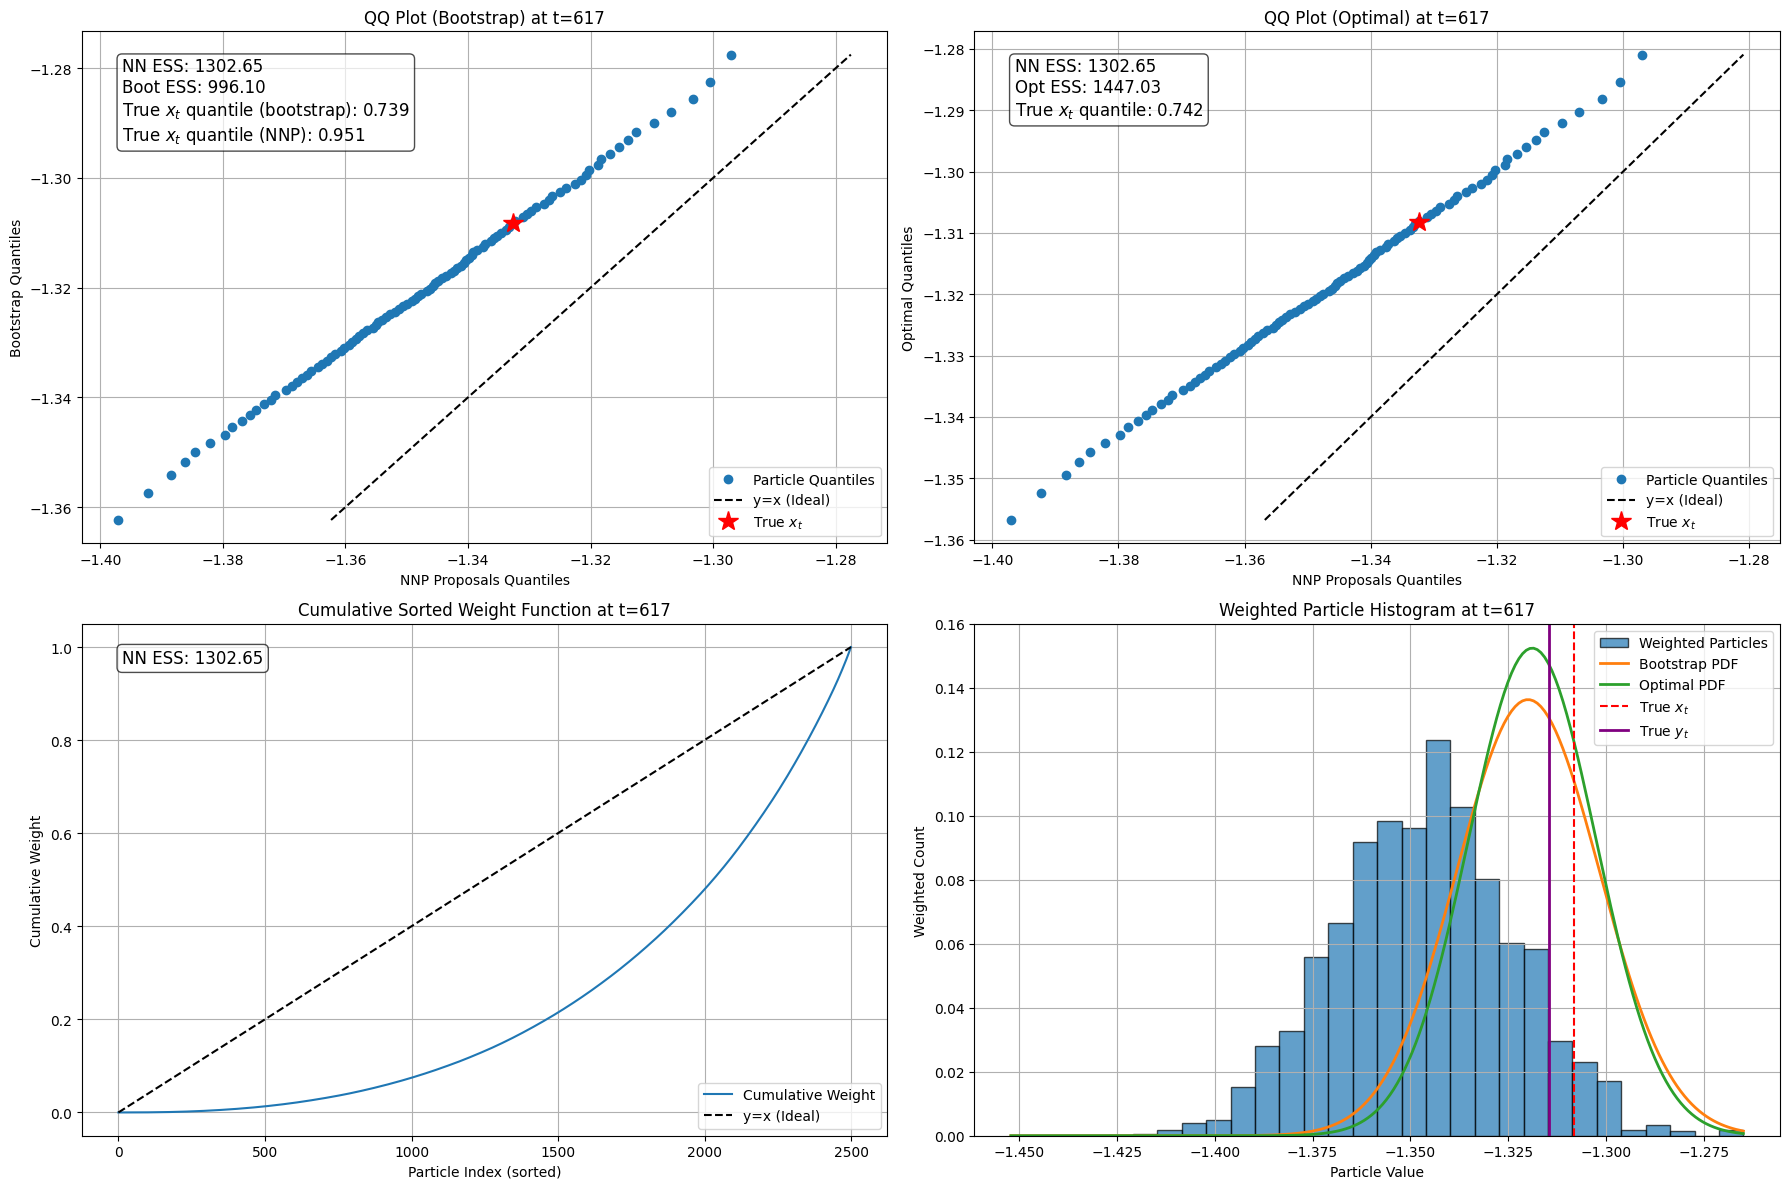

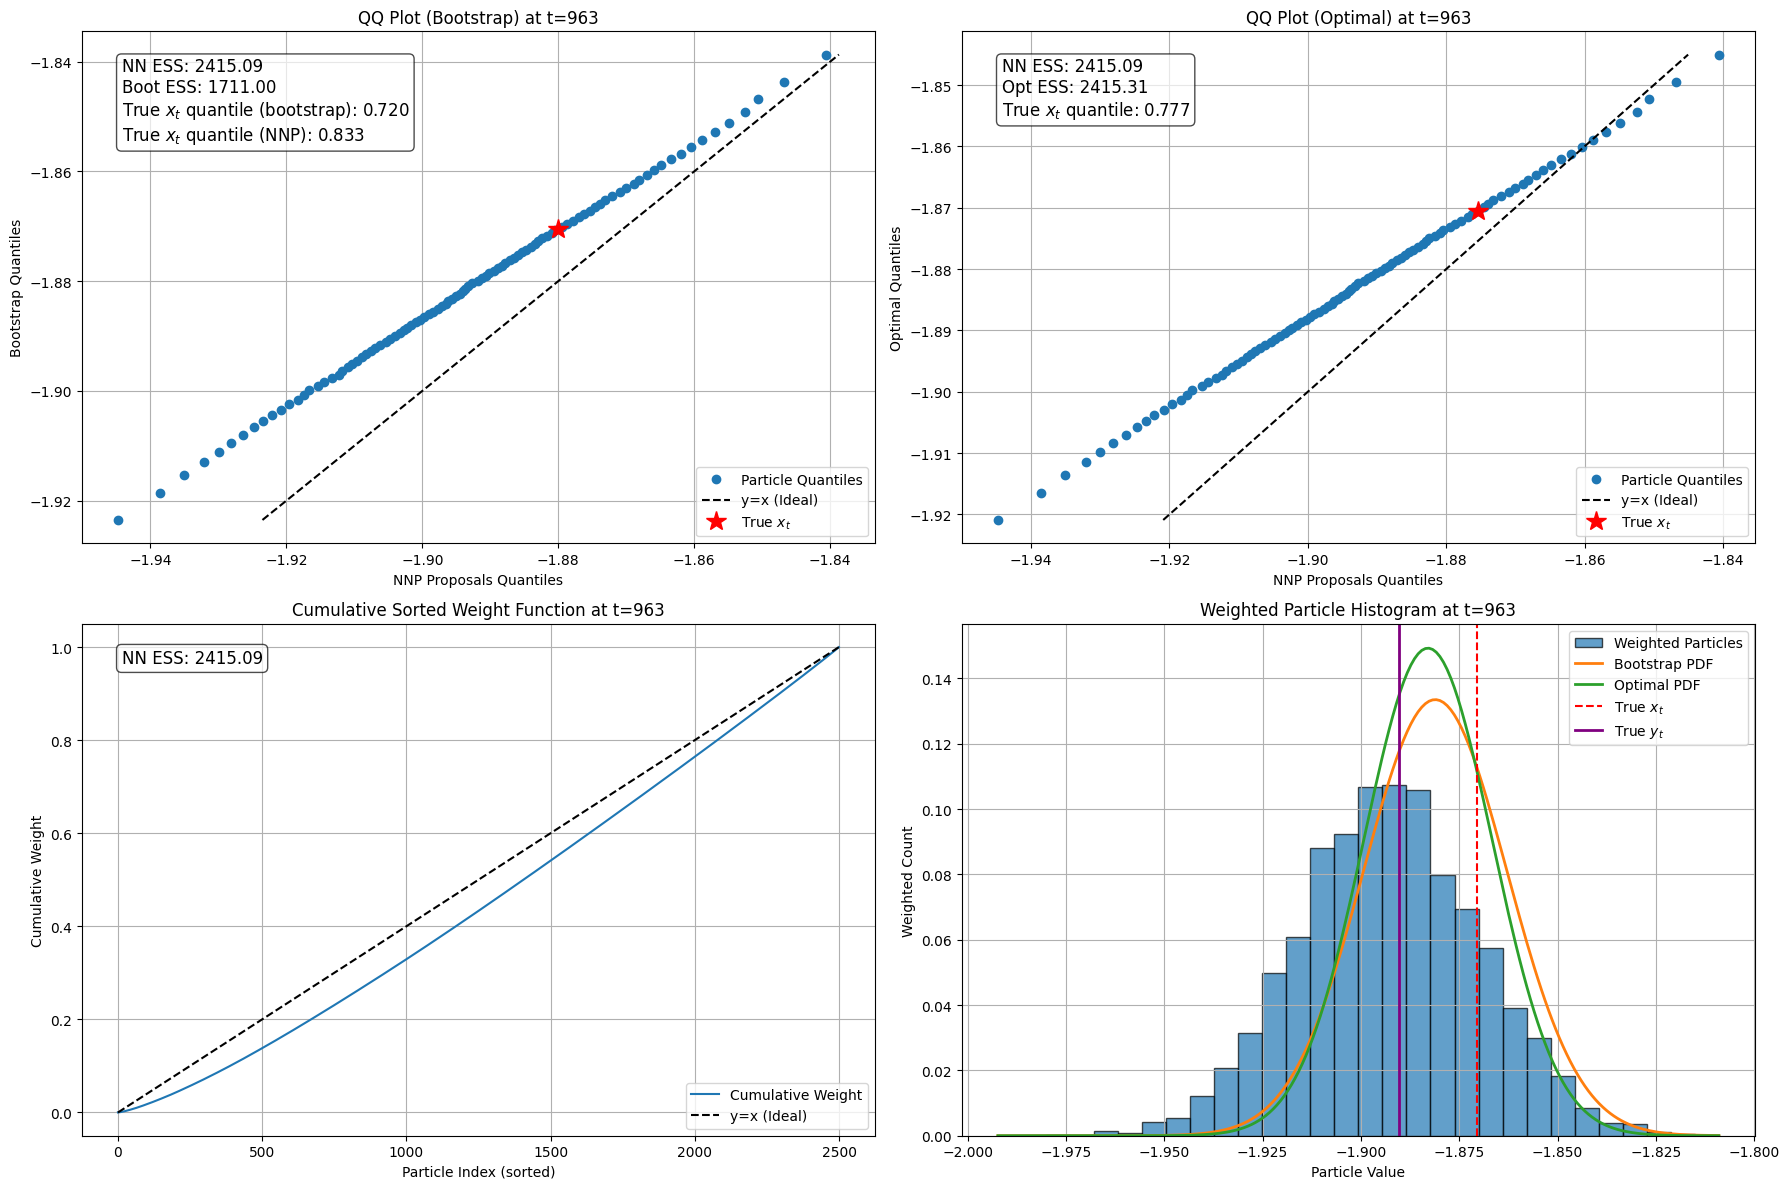

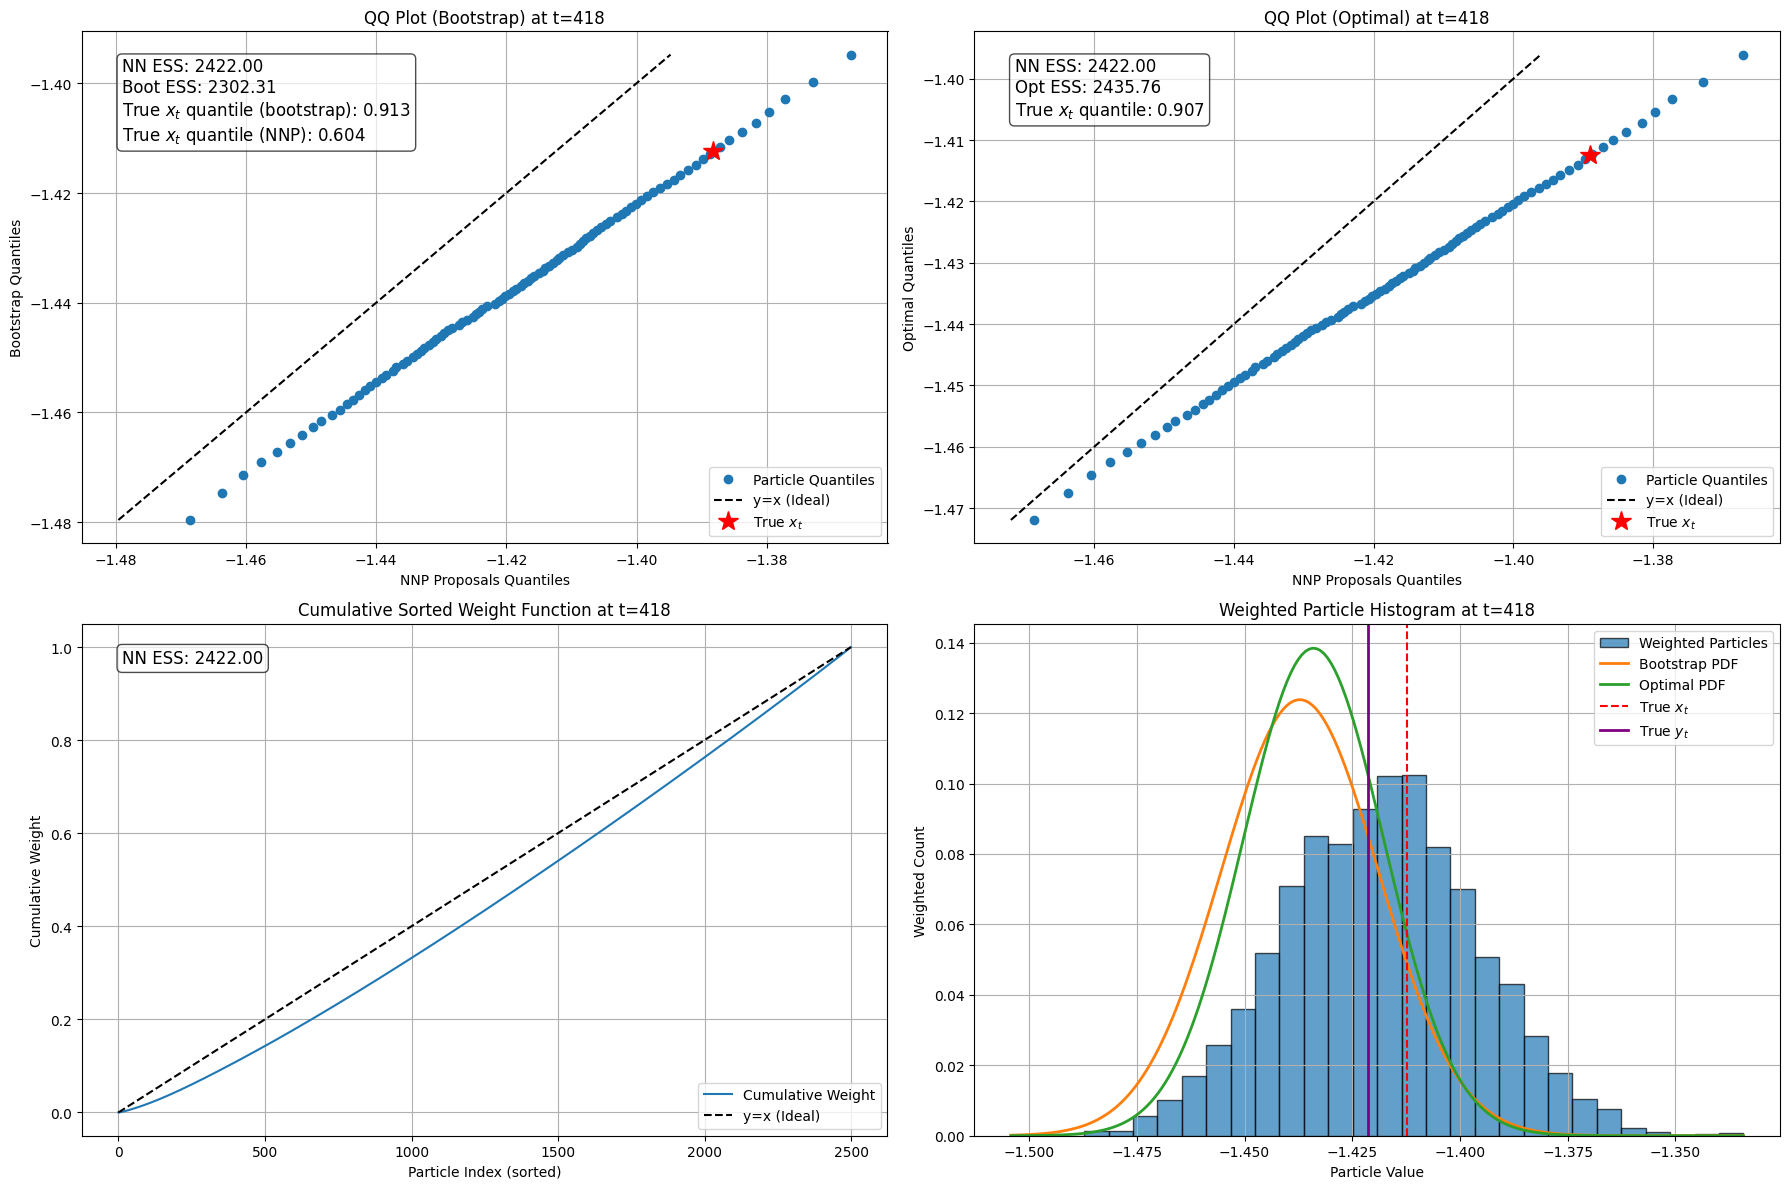

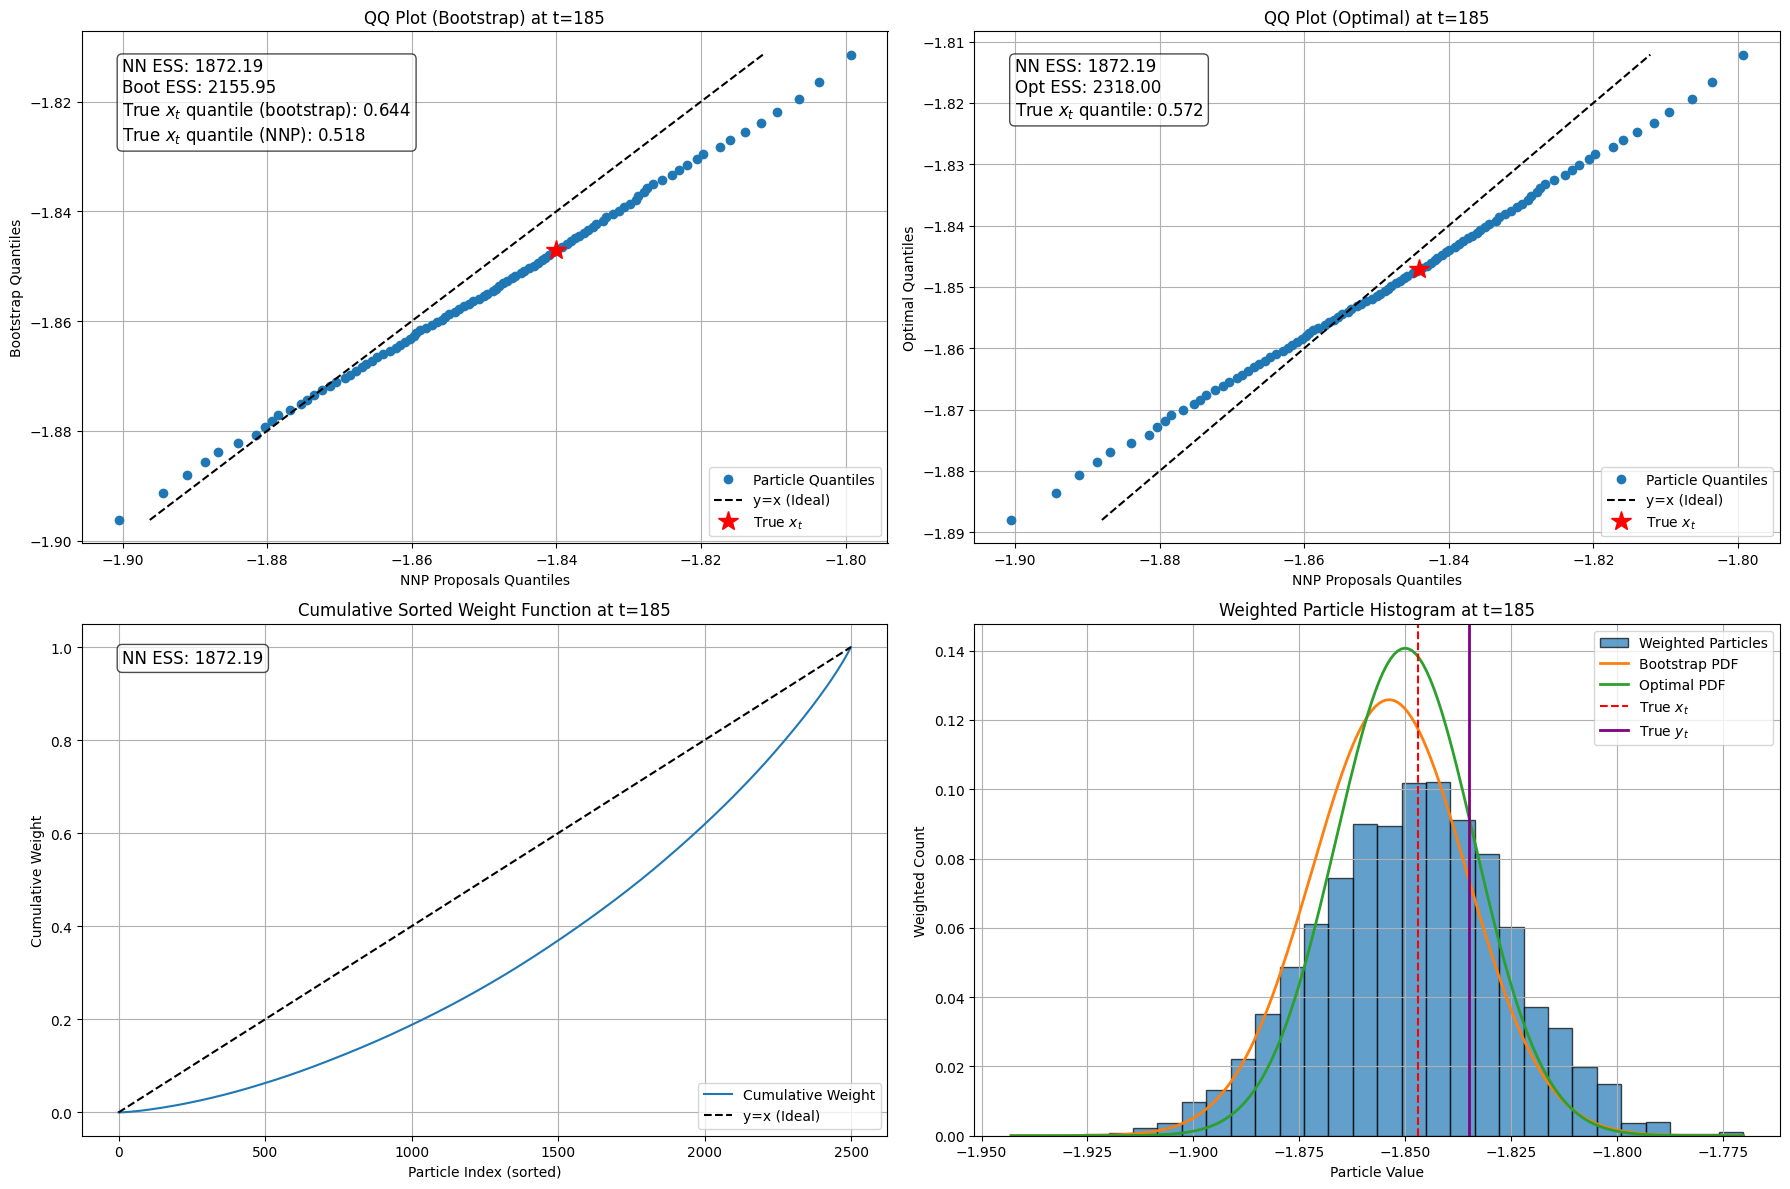

In [82]:
all_particles, all_weights = nn_output_particles_and_weights
first_particles, first_weights = all_particles[0], all_weights[0]

nn_ess, opt_ess, boot_ess = nn_diagnostics['ess'][0], optimal_diagnostics['ess'][0], bootstrap_diagnostics['ess'][0]

print('worst')
for idx in first_three:
    create_qq_plot((first_particles, first_weights), x_vals[0], y_vals[0], idx, nn_ess[idx], opt_ess[idx], boot_ess[idx])

print('best')
for idx in last_three:
    create_qq_plot((first_particles, first_weights), x_vals[0], y_vals[0], idx, nn_ess[idx], opt_ess[idx], boot_ess[idx])

print('random')
for idx in rand_three:
    create_qq_plot((first_particles, first_weights), x_vals[0], y_vals[0], idx, nn_ess[idx], opt_ess[idx], boot_ess[idx])

    